# Intro

The functions described in this notebook make extensive use of LOWESS (also known as LOESS) curve-smoothing. There are many implementations of LOESS fitting in python, but these functions use the lowess() function described here:
https://www.statsmodels.org/devel/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html

LOESS curve-smoothing generates new data points following the general trend of the data. This is done through local least squares fitting at each data point, and a 'fraction' input variable controls how much of the total dataset is considered when making these local fits. A lower 'fraction' captures more local behaviour.

# Setup

Since these changes have not been implemented into the pylenm package on pip, we have to manually set up this version of pylenm by running the code block below.

*The below code block should be changed to `pip install pylenm` before publishing this example notebook.*

In [1]:
# # Required imports
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pylab
import scipy
import random
import datetime
import re
import time
from math import sqrt
import matplotlib.dates as mdates
from statsmodels.nonparametric.smoothers_lowess import lowess
from matplotlib.dates import date2num, num2date
from sklearn import preprocessing
from scipy.optimize import curve_fit
from supersmoother import SuperSmoother
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.gaussian_process.kernels import Matern, WhiteKernel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings("ignore")
from pyproj import Proj, Transformer
from ipyleaflet import (Map, basemaps, WidgetControl, GeoJSON, 
                        LayersControl, Icon, Marker,FullScreenControl,
                        CircleMarker, Popup, AwesomeIcon) 
from ipywidgets import HTML
plt.rcParams["font.family"] = "Times New Roman"

class PylenmDataFactory(object):
    """Class object that initilaizes Pylenm given data.
    """
    
    def __init__(self, data: pd.DataFrame):
            """Initlizes pylenm with a Pandas DataFrame

            Args:
                data (pd.DataFrame): Data to be imported.
            """
            self.setData(data)
            self.__jointData = [None, 0]

    # DATA VALIDATION     
    def __isValid_Data(self, data):
        if(str(type(data)).lower().find('dataframe') == -1):
            return (False, 'Make sure the data is a pandas DataFrame.\n')
        if(not self.__hasColumns_Data(data)):
            return (False, 'Make sure that ALL of the columns specified in the REQUIREMENTS are present.\n')
        else:
            return (True, None)

    def __isValid_Construction_Data(self, data):
        if(str(type(data)).lower().find('dataframe') == -1):
            return (False, 'Make sure the data is a pandas DataFrame.\n')
        if(not self.__hasColumns_Construction_Data(data)):
            return (False, 'Make sure that ALL of the columns specified in the REQUIREMENTS are present.\n')
        else:
            return (True, None)

    # COLUMN VALIDATION 
    def __hasColumns_Data(self, data):
        find = ['COLLECTION_DATE','STATION_ID','ANALYTE_NAME','RESULT','RESULT_UNITS']
        cols = list(data.columns)
        cols = [x.upper() for x in cols]
        hasCols =  all(item in cols for item in find)
        return hasCols

    def __hasColumns_Construction_Data(self, data):
        find = ['STATION_ID', 'AQUIFER', 'STATION_USE', 'LATITUDE', 'LONGITUDE', 'GROUND_ELEVATION', 'TOTAL_DEPTH']
        cols = list(data.columns)
        cols = [x.upper() for x in cols]
        hasCols =  all(item in cols for item in find)
        return hasCols

    # SETTING DATA
    def setData(self, data: pd.DataFrame, verbose: bool = True) -> None:
        """Saves the dataset into pylenm

        Args:
            data (pd.DataFrame): Dataset to be imported.
            verbose (bool, optional): Prints success message. Defaults to True.

        Returns:
            None
        """
        validation = self.__isValid_Data(data)
        if(validation[0]):
            # Make all columns all caps
            cols_upper = [x.upper() for x in list(data.columns)]
            data.columns = cols_upper
            self.data = data
            if(verbose):
                print('Successfully imported the data!\n')
            self.__set_units()
        else:
            print('ERROR: {}'.format(validation[1]))
            return self.__REQUIREMENTS_DATA()

    def setConstructionData(self, construction_data: pd.DataFrame, verbose=True):
        """Imports the addtitional monitoring station information as a separate DataFrame.

        Args:
            construction_data (pd.DataFrame): Data with additonal details.
            verbose (bool, optional): Prints success message. Defaults to True.

        Returns:
            None
        """
        validation = self.__isValid_Construction_Data(construction_data)
        if(validation[0]):
            # Make all columns all caps
            cols_upper = [x.upper() for x in list(construction_data.columns)]
            construction_data.columns = cols_upper
            self.construction_data = construction_data.set_index(['STATION_ID'])
            if(verbose):
                print('Successfully imported the construction data!\n')
        else:
            print('ERROR: {}'.format(validation[1]))
            return self.__REQUIREMENTS_CONSTRUCTION_DATA()

    def jointData_is_set(self, lag):
        """Checks to see if getJointData function was already called and saved for given lag.

        Args:
            lag (int): number of days to look ahead and behind the specified date (+/-)

        Returns:
            bool: True if JointData was already calculated, False, otherwise.
        """
        if(str(type(self.__jointData[0])).lower().find('dataframe') == -1):
            return False
        else:
            if(self.__jointData[1]==lag):
                return True
            else:
                return False

    def __set_jointData(self, data, lag):
        self.__jointData[0] = data
        self.__jointData[1] = lag

    # GETTING DATA      
    def getData(self):
        """Returns the concentration data in pylenm 

        Returns:
            pd.DataFrame: concentration data that was passed into pylenm
        """
        return self.data

    def get_Construction_Data(self):
        """Returns the construction data in pylenm 

        Returns:
            pd.DataFrame: construction data that was passed into pylenm
        """
        return self.construction_data

    # MESSAGES FOR INVALID DATA          
    def __REQUIREMENTS_DATA(self):
        print('PYLENM DATA REQUIREMENTS:\nThe imported data needs to meet ALL of the following conditions to have a successful import:')
        print('   1) Data should be a pandas dataframe.')
        print("   2) Data must have these column names: \n      ['COLLECTION_DATE','STATION_ID','ANALYTE_NAME','RESULT','RESULT_UNITS']")

    def __REQUIREMENTS_CONSTRUCTION_DATA(self):
        print('PYLENM CONSTRUCTION REQUIREMENTS:\nThe imported construction data needs to meet ALL of the following conditions to have a successful import:')
        print('   1) Data should be a pandas dataframe.')
        print("   2) Data must have these column names: \n      ['station_id', 'aquifer', 'station_use', 'latitude', 'longitude', 'ground_elevation', 'total_depth']")

    # Helper function for plot_correlation
    # Sorts analytes in a specific order: 'TRITIUM', 'URANIUM-238','IODINE-129','SPECIFIC CONDUCTANCE', 'PH', 'DEPTH_TO_WATER'
    def __custom_analyte_sort(self, analytes):
        my_order = 'TURISPDABCEFGHJKLMNOQVWXYZ-_abcdefghijklmnopqrstuvwxyz135790 2468'
        return sorted(analytes, key=lambda word: [my_order.index(c) for c in word])

    def __plotUpperHalf(self, *args, **kwargs):
        corr_r = args[0].corr(args[1], 'pearson')
        corr_text = f"{corr_r:2.2f}"
        ax = plt.gca()
        ax.set_axis_off()
        marker_size = abs(corr_r) * 10000
        ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
                    vmin=-1, vmax=1, transform=ax.transAxes)
        font_size = abs(corr_r) * 40 + 5
        ax.annotate(corr_text, [.5, .48,],  xycoords="axes fraction", # [.5, .48,]
                    ha='center', va='center', fontsize=font_size, fontweight='bold')


    def simplify_data(self, data=None, inplace=False, columns=None, save_csv=False, file_name= 'data_simplified', save_dir='data/'):
        """Removes all columns except 'COLLECTION_DATE', 'STATION_ID', 'ANALYTE_NAME', 'RESULT', and 'RESULT_UNITS'.
            
            If the user specifies additional columns in addition to the ones listed above, those columns will be kept.
            The function returns a dataframe and has an optional parameter to be able to save the dataframe to a csv file.

        Args:
            data (pd.DataFrame, optional): data to simplify. Defaults to None.
            inplace (bool, optional): save data to current working dataset. Defaults to False.
            columns (list, optional): list of any additional columns on top of  ['COLLECTION_DATE', 'STATION_ID', 'ANALYTE_NAME', 'RESULT', and 'RESULT_UNITS'] to be kept in the dataframe. Defaults to None.
            save_csv (bool, optional): flag to determine whether or not to save the dataframe to a csv file. Defaults to False.
            file_name (str, optional): name of the csv file you want to save. Defaults to 'data_simplified'.
            save_dir (str, optional): name of the directory you want to save the csv file to. Defaults to 'data/'.

        Returns:
            pd.DataFrame
        """
        if(str(type(data)).lower().find('dataframe') == -1):
            data = self.data
        else:
            data = data
        if(columns==None):
            sel_cols = ['COLLECTION_DATE','STATION_ID','ANALYTE_NAME','RESULT','RESULT_UNITS']
        else:
            hasColumns =  all(item in list(data.columns) for item in columns)
            if(hasColumns):            
                sel_cols = ['COLLECTION_DATE','STATION_ID','ANALYTE_NAME','RESULT','RESULT_UNITS'] + columns
            else:
                print('ERROR: specified column(s) do not exist in the data')
                return None

        data = data[sel_cols]
        data.COLLECTION_DATE = pd.to_datetime(data.COLLECTION_DATE)
        data = data.sort_values(by="COLLECTION_DATE")
        dup = data[data.duplicated(['COLLECTION_DATE', 'STATION_ID','ANALYTE_NAME', 'RESULT'])]
        data = data.drop(dup.index)
        data = data.reset_index().drop('index', axis=1)
        if(save_csv):
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            data.to_csv(save_dir + file_name + '.csv')
            print('Successfully saved "' + file_name +'.csv" in ' + save_dir)
        if(inplace):
            self.setData(data, verbose=False)
        return data

    def get_MCL(self, analyte_name):
        """Returns the Maximum Concentration Limit value for the specified analyte. Example: 'TRITIUM' returns 1.3

        Args:
            analyte_name (str): name of the analyte to be processed

        Returns:
            float: MLC value
        """
        mcl_dictionary = {'TRITIUM': 1.3, 'URANIUM-238': 1.31,  'NITRATE-NITRITE AS NITROGEN': 1,
                            'TECHNETIUM-99': 2.95, 'IODINE-129': 0, 'STRONTIUM-90': 0.9
                            }
        return mcl_dictionary[analyte_name]

    def __set_units(self):
        analytes = list(np.unique(self.data[['ANALYTE_NAME']]))
        mask1 = ~self.data[['ANALYTE_NAME','RESULT_UNITS']].duplicated()
        res = self.data[['ANALYTE_NAME','RESULT_UNITS']][mask1]
        mask2 = ~self.data[['ANALYTE_NAME']].duplicated()
        res = res[mask2]
        unit_dictionary = pd.Series(res.RESULT_UNITS.values,index=res.ANALYTE_NAME).to_dict()
        self.unit_dictionary = unit_dictionary
        
    def get_unit(self, analyte_name):
        """Returns the unit of the analyte you specify. Example: 'DEPTH_TO_WATER' may return 'ft'

        Args:
            analyte_name (str): ame of the analyte to be processed

        Returns:
            str: unit of analyte
        """
        return self.unit_dictionary[analyte_name]

    def filter_by_column(self, data=None, col=None, equals=[]):
        """Filters construction data based on one column. You only specify ONE column to filter by, but can selected MANY values for the entry.

        Args:
            data (pd.DataFrame, optional): dataframe to filter. Defaults to None.
            col (str, optional): column to filter. Example: col='STATION_ID'. Defaults to None.
            equals (list, optional): values to filter col by. Examples: equals=['FAI001A', 'FAI001B']. Defaults to [].

        Returns:
            pd.DataFrame: returns filtered dataframe
        """
        if(data is None):
            return 'ERROR: DataFrame was not provided to this function.'
        else:
            if(str(type(data)).lower().find('dataframe') == -1):
                return 'ERROR: Data provided is not a pandas DataFrame.'
            else:
                data = data
        # DATA VALIDATION
        if(col==None):
            return 'ERROR: Specify a column name to filter by.'
        data_cols = list(data.columns)
        if((col in data_cols)==False): # Make sure column name exists 
            return 'Error: Column name "{}" does not exist'.format(col)
        if(equals==[]):
            return 'ERROR: Specify a value that "{}" should equal to'.format(col)
        data_val = list(data[col])
        for value in equals:
            if((value in data_val)==False):
                return 'ERROR: No value equal to "{}" in "{}".'.format(value, col)

        # QUERY
        final_data = pd.DataFrame()
        for value in equals:
            current_data = data[data[col]==value]
            final_data = pd.concat([final_data, current_data])
        return final_data

    def filter_stations(self, units):
        """Returns a list of the station names filtered by the unit(s) specified.

        Args:
            units (list): Letter of the station to be filtered (e.g. [‘A’] or [‘A’, ‘D’])

        Returns:
            list: station names filtered by the unit(s) specified
        """
        data = self.data
        if(units==None):
            units= ['A', 'B', 'C', 'D']
        def getUnits():
            stations = list(np.unique(data.STATION_ID))
            stations = pd.DataFrame(stations, columns=['STATION_ID'])
            for index, row in stations.iterrows():
                mo = re.match('.+([0-9])[^0-9]*$', row.STATION_ID)
                last_index = mo.start(1)
                stations.at[index, 'unit'] = row.STATION_ID[last_index+1:]
                u = stations.unit.iloc[index]
                if(len(u)==0): # if has no letter, use D
                    stations.at[index, 'unit'] = 'D'
                if(len(u)>1): # if has more than 1 letter, remove the extra letter
                    if(u.find('R')>0):
                        stations.at[index, 'unit'] = u[:-1]
                    else:
                        stations.at[index, 'unit'] = u[1:]
                u = stations.unit.iloc[index]
                if(u=='A' or u=='B' or u=='C' or u=='D'):
                    pass
                else:
                    stations.at[index, 'unit'] = 'D'
            return stations
        df = getUnits()
        res = df.loc[df.unit.isin(units)]
        return list(res.STATION_ID)

    def remove_outliers(self, data, z_threshold=4):
        """Removes outliers from a dataframe based on the z_scores and returns the new dataframe.

        Args:
            data (pd.DataFrame): data for the outliers to removed from
            z_threshold (int, optional): z_score threshold to eliminate. Defaults to 4.

        Returns:
            pd.DataFrame: data with outliers removed
        """
        z = np.abs(stats.zscore(data))
        row_loc = np.unique(np.where(z > z_threshold)[0])
        data = data.drop(data.index[row_loc])
        return data

    def get_analyte_details(self, analyte_name, filter=False, col=None, equals=[], save_to_file = False, save_dir='analyte_details'):
        """Returns a csv file saved to save_dir with details pertaining to the specified analyte. Details include the station names, the date ranges and the number of unique samples.

        Args:
            analyte_name (str): name of the analyte to be processed
            filter (bool, optional): whether to filter the data. Defaults to False.
            col (str, optional): column to filter. Example: col='STATION_ID'. Defaults to None.
            equals (list, optional): values to filter col by. Examples: equals=['FAI001A', 'FAI001B']. Defaults to [].
            save_to_file (bool, optional): whether to save data to file. Defaults to False.
            save_dir (str, optional): name of the directory you want to save the csv file to. Defaults to 'analyte_details'.

        Returns:
            pd.DataFrame: Table with station information
        """
        data = self.data
        data = data[data.ANALYTE_NAME == analyte_name].reset_index().drop('index', axis=1)
        data = data[~data.RESULT.isna()]
        data = data.drop(['ANALYTE_NAME', 'RESULT', 'RESULT_UNITS'], axis=1)
        data.COLLECTION_DATE = pd.to_datetime(data.COLLECTION_DATE)
        if(filter):
            filter_res = self.filter_by_column(data=self.construction_data, col=col, equals=equals)
            if('ERROR:' in str(filter_res)):
                return filter_res
            query_stations = list(data.STATION_ID.unique())
            filter_stations = list(filter_res.index.unique())
            intersect_stations = list(set(query_stations) & set(filter_stations))
            if(len(intersect_stations)<=0):
                return 'ERROR: No results for this query with the specifed filter parameters.'
            data = data[data['STATION_ID'].isin(intersect_stations)]        

        info = []
        stations = np.unique(data.STATION_ID.values)
        for station in stations:
            current = data[data.STATION_ID == station]
            startDate = current.COLLECTION_DATE.min().date()
            endDate = current.COLLECTION_DATE.max().date()
            numSamples = current.duplicated().value_counts()[0]
            info.append({'Station Name': station, 'Start Date': startDate, 'End Date': endDate,
                            'Date Range (days)': endDate-startDate ,
                            'Unique samples': numSamples})
            details = pd.DataFrame(info)
            details.index = details['Station Name']
            details = details.drop('Station Name', axis=1)
            details = details.sort_values(by=['Start Date', 'End Date'])
            details['Date Range (days)'] = (details['Date Range (days)']/ np.timedelta64(1, 'D')).astype(int)
        if(save_to_file):
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            details.to_csv(save_dir + '/' + analyte_name + '_details.csv')
        return details

    def get_data_summary(self, analytes=None, sort_by='date', ascending=False, filter=False, col=None, equals=[]):
        """Returns a dataframe with a summary of the data for certain analytes. Summary includes the date ranges and the number of unique samples and other statistics for the analyte results.

        Args:
            analytes (list, optional): list of analyte names to be processed. If left empty, a list of all the analytes in the data will be used. Defaults to None.
            sort_by (str, optional): {‘date’, ‘samples’, ‘stations’} sorts the data by either the dates by entering: ‘date’, the samples by entering: ‘samples’, or by unique station locations by entering ‘stations’. Defaults to 'date'.
            ascending (bool, optional): flag to sort in ascending order.. Defaults to False.
            filter (bool, optional): flag to indicate filtering. Defaults to False.
            col (str, optional): column to filter. Example: col='STATION_ID'. Defaults to None.
            equals (list, optional): values to filter col by. Examples: equals=['FAI001A', 'FAI001B']. Defaults to [].

        Returns:
            pd.DataFrame: Table with station information
        """
        data = self.data
        if(analytes == None):
            analytes = data.ANALYTE_NAME.unique()
        data = data.loc[data.ANALYTE_NAME.isin(analytes)].drop(['RESULT_UNITS'], axis=1)
        data = data[~data.duplicated()] # remove duplicates
        data.COLLECTION_DATE = pd.to_datetime(data.COLLECTION_DATE)
        data = data[~data.RESULT.isna()]
        if(filter):
            filter_res = self.filter_by_column(data=self.construction_data, col=col, equals=equals)
            if('ERROR:' in str(filter_res)):
                return filter_res
            query_stations = list(data.STATION_ID.unique())
            filter_stations = list(filter_res.index.unique())
            intersect_stations = list(set(query_stations) & set(filter_stations))
            if(len(intersect_stations)<=0):
                return 'ERROR: No results for this query with the specifed filter parameters.'
            data = data[data['STATION_ID'].isin(intersect_stations)]

        info = []
        for analyte_name in analytes:
            query = data[data.ANALYTE_NAME == analyte_name]
            startDate = min(query.COLLECTION_DATE)
            endDate = max(query.COLLECTION_DATE)
            numSamples = query.shape[0]
            stationCount = len(query.STATION_ID.unique())
            stats = query.RESULT.describe().drop('count', axis=0)
            stats = pd.DataFrame(stats).T
            stats_col = [x for x in stats.columns]

            result = {'Analyte Name': analyte_name, 'Start Date': startDate, 'End Date': endDate,
                        'Date Range (days)':endDate-startDate, '# unique stations': stationCount,'# samples': numSamples,
                        'Unit': self.get_unit(analyte_name) }
            for num in range(len(stats_col)):
                result[stats_col[num]] = stats.iloc[0][num] 

            info.append(result)

            details = pd.DataFrame(info)
            details.index = details['Analyte Name']
            details = details.drop('Analyte Name', axis=1)
            if(sort_by.lower() == 'date'):
                details = details.sort_values(by=['Start Date', 'End Date', 'Date Range (days)'], ascending=ascending)
            elif(sort_by.lower() == 'samples'):
                details = details.sort_values(by=['# samples'], ascending=ascending)
            elif(sort_by.lower() == 'stations'):
                details = details.sort_values(by=['# unique stations'], ascending=ascending)

        return details

    def get_station_analytes(self, station_name=None, filter=False, col=None, equals=[]):
        """Displays the analyte names available at given station locations.

        Args:
            station_name (str, optional): name of the station. If left empty, all stations are returned.. Defaults to None.
            filter (bool, optional): flag to indicate filtering. Defaults to False.
            col (str, optional): column to filter. Example: col='STATION_ID'. Defaults to None.
            equals (list, optional): values to filter col by. Examples: equals=['FAI001A', 'FAI001B']. Defaults to [].

        Returns:
            None
        """
        data = self.data
        bb = "\033[1m"
        be = "\033[0m"
        if(filter):
            filter_res = self.filter_by_column(data=self.construction_data, col=col, equals=equals)
            if('ERROR:' in str(filter_res)):
                return filter_res
            query_stations = list(data.STATION_ID.unique())
            filter_stations = list(filter_res.index.unique())
            intersect_stations = list(set(query_stations) & set(filter_stations))
            if(len(intersect_stations)<=0):
                return 'ERROR: No results for this query with the specifed filter parameters.'
            data = data[data['STATION_ID'].isin(intersect_stations)]
        
        if(station_name==None):
            stations = list(data.STATION_ID.unique())
        else:
            stations = [station_name]
        for station in stations:
            print("{}{}{}".format(bb,str(station), be))
            analytes = sorted(list(data[data.STATION_ID==station].ANALYTE_NAME.unique()))
            print(str(analytes) +'\n')


    def query_data(self, station_name, analyte_name):
        """Filters data by passing the data and specifying the station_name and analyte_name

        Args:
            station_name (str): name of the station to be processed
            analyte_name (str): name of the analyte to be processed

        Returns:
            pd.DataFrame: filtered data based on query conditons
        """
        data = self.data
        query = data[data.STATION_ID == station_name]
        query = query[query.ANALYTE_NAME == analyte_name]
        if(query.shape[0] == 0):
            return 0
        else:
            return query
    
    def plot_data(self, station_name, analyte_name, log_transform=True, alpha=0,
              plot_inline=True, year_interval=2, x_label='Years', y_label='', save_dir='plot_data', filter=False, col=None, equals=[]):
        """Plot concentrations over time of a specified station and analyte with a smoothed curve on interpolated data points.

        Args:

            station_name (str): name of the station to be processed
            analyte_name (str): name of the analyte to be processed
            log_transform (bool, optional): choose whether or not the data should be transformed to log base 10 values. Defaults to True.
            alpha (int, optional): alue between 0 and 10 for line smoothing. Defaults to 0.
            plot_inline (bool, optional): choose whether or not to show plot inline. Defaults to True.
            year_interval (int, optional): plot by how many years to appear in the axis e.g.(1 = every year, 5 = every 5 years, ...). Defaults to 2.
            x_label (str, optional): x axis label. Defaults to 'Years'.
            y_label (str, optional): y axis label. Defaults to ''.
            save_dir (str, optional): name of the directory you want to save the plot to. Defaults to 'plot_data'.
            filter (bool, optional): flag to indicate filtering. Defaults to False.
            col (str, optional): column to filter. Example: col='STATION_ID'. Defaults to None.
            equals (list, optional): values to filter col by. Examples: equals=['FAI001A', 'FAI001B']. Defaults to [].

        Returns:
            None
        """
    
        # Gets appropriate data (station_name and analyte_name)
        query = self.query_data(station_name, analyte_name)
        query = self.simplify_data(data=query)

        if(type(query)==int and query == 0):
            return 'No results found for {} and {}'.format(station_name, analyte_name)
        else:
            if(filter):
                filter_res = self.filter_by_column(data=self.construction_data, col=col, equals=equals)
                if('ERROR:' in str(filter_res)):
                    return filter_res
                query_stations = list(query.STATION_ID.unique())
                filter_stations = list(filter_res.index.unique())
                intersect_stations = list(set(query_stations) & set(filter_stations))
                if(len(intersect_stations)<=0):
                    return 'ERROR: No results for this query with the specifed filter parameters.'
                query = query[query['STATION_ID'].isin(intersect_stations)]
            x_data = query.COLLECTION_DATE
            x_data = pd.to_datetime(x_data)
            y_data = query.RESULT
            if(log_transform):
                y_data = np.log10(y_data)

            x_RR = x_data.astype(int).to_numpy()

            nu = x_data.shape[0]

            model = SuperSmoother(alpha=alpha)
            model.fit(x_RR, y_data)
            y_pred = model.predict(x_RR)
            r = model.cv_residuals()
            out = abs(r) > 2.2*np.std(r)
            out_x = x_data[out]
            out_y = y_data[out]

            plt.figure(figsize=(8,8))
            ax = plt.axes()
            years = mdates.YearLocator(year_interval)  # every year
            months = mdates.MonthLocator()  # every month
            yearsFmt = mdates.DateFormatter('%Y')

            for label in ax.get_xticklabels():
                label.set_rotation(30)
                label.set_horizontalalignment('center')

            ax = plt.gca()
            ax.xaxis.set_major_locator(years)
            ax.xaxis.set_major_formatter(yearsFmt)
            ax.autoscale_view()

            unit = query.RESULT_UNITS.values[0]

            ax.set_title(str(station_name) + ' - ' + analyte_name, fontweight='bold')
            ttl = ax.title
            ttl.set_position([.5, 1.05])
            if(y_label==''):    
                if(log_transform):
                    ax.set_ylabel('log-Concentration (' + unit + ')')
                else:
                    ax.set_ylabel('Concentration (' + unit + ')')
            else:
                ax.set_ylabel(y_label)
            ax.set_xlabel(x_label)
            small_fontSize = 15
            large_fontSize = 20
            plt.rc('axes', titlesize=large_fontSize)
            plt.rc('axes', labelsize=large_fontSize)
            plt.rc('legend', fontsize=small_fontSize)
            plt.rc('xtick', labelsize=small_fontSize)
            plt.rc('ytick', labelsize=small_fontSize) 
            ax.plot(x_data, y_data, ls='', marker='o', ms=5, color='black', alpha=1)
            ax.plot(x_data, y_pred, ls='-', marker='', ms=5, lw=2, color='blue', alpha=0.5, label="Super Smoother")
            ax.plot(out_x , out_y, ls='', marker='o', ms=5, color='red', alpha=1, label="Outliers")
            ax.legend(bbox_to_anchor=(1.04, 1), loc='upper left', borderaxespad=0.)
            props = dict(boxstyle='round', facecolor='grey', alpha=0.15)       
            ax.text(1.05, 0.85, 'Samples: {}'.format(nu), transform=ax.transAxes, 
                    fontsize=small_fontSize,
                    fontweight='bold',
                    verticalalignment='top', 
                    bbox=props)
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            # plt.savefig(save_dir + '/' + str(station_name) + '-' + analyte_name +'.png', bbox_inches="tight")
            if(plot_inline):
                plt.show()
            plt.clf()
            plt.cla()
            plt.close()


    def plot_all_data(self, log_transform=True, alpha=0, year_interval=2, plot_inline=True, save_dir='plot_data'):
        """Plot concentrations over time for every station and analyte with a smoothed curve on interpolated data points.

        Args:
            log_transform (bool, optional): choose whether or not the data should be transformed to log base 10 values. Defaults to True.
            alpha (int, optional): alue between 0 and 10 for line smoothing. Defaults to 0.
            plot_inline (bool, optional): choose whether or not to show plot inline. Defaults to True.
            year_interval (int, optional): plot by how many years to appear in the axis e.g.(1 = every year, 5 = every 5 years, ...). Defaults to 2.
            save_dir (str, optional): name of the directory you want to save the plot to. Defaults to 'plot_data'.
        """
        analytes = ['TRITIUM','URANIUM-238','IODINE-129','SPECIFIC CONDUCTANCE', 'PH', 'DEPTH_TO_WATER']
        stations = np.array(self.data.STATION_ID.values)
        stations = np.unique(stations)
        success = 0
        errors = 0
        for station in stations:
            for analyte in analytes:
                plot = self.plot_data(station, analyte, 
                                    log_transform=log_transform, 
                                    alpha=alpha, 
                                    year_interval=year_interval,
                                    plot_inline=plot_inline,
                                    save_dir=save_dir)
                if 'ERROR:' in str(plot):
                    errors = errors + 1
                else:
                    success = success + 1
        print("Success: ", success)
        print("Errors: ", errors)

    def plot_correlation_heatmap(self, station_name, show_symmetry=True, color=True, save_dir='plot_correlation_heatmap'):
        """ Plots a heatmap of the correlations of the important analytes over time for a specified station.

        Args:
            station_name (str): name of the station to be processed
            show_symmetry (bool, optional): choose whether or not the heatmap should show the same information twice over the diagonal. Defaults to True.
            color (bool, optional): choose whether or not the plot should be in color or in greyscale. Defaults to True.
            save_dir (str, optional): name of the directory you want to save the plot to. Defaults to 'plot_correlation_heatmap'.

        Returns:
            None
        """
        data = self.data
        query = data[data.STATION_ID == station_name]
        a = list(np.unique(query.ANALYTE_NAME.values))
        b = ['TRITIUM','IODINE-129','SPECIFIC CONDUCTANCE', 'PH','URANIUM-238', 'DEPTH_TO_WATER']
        analytes = self.__custom_analyte_sort(list(set(a) and set(b)))
        query = query.loc[query.ANALYTE_NAME.isin(analytes)]
        analytes = self.__custom_analyte_sort(np.unique(query.ANALYTE_NAME.values))
        x = query[['COLLECTION_DATE', 'ANALYTE_NAME']]
        unique = ~x.duplicated()
        query = query[unique]
        piv = query.reset_index().pivot(index='COLLECTION_DATE',columns='ANALYTE_NAME', values='RESULT')
        piv = piv[analytes]
        totalSamples = piv.shape[0]
        piv = piv.dropna()
        samples = piv.shape[0]
        if(samples < 5):
            return 'ERROR: {} does not have enough samples to plot.'.format(station_name)
        else:
            scaler = StandardScaler()
            pivScaled = scaler.fit_transform(piv)
            pivScaled = pd.DataFrame(pivScaled, columns=piv.columns)
            pivScaled.index = piv.index
            corr_matrix = pivScaled.corr()
            if(show_symmetry):
                mask = None
            else:
                mask = np.triu(corr_matrix)
            if(color):
                cmap = 'RdBu'
            else:
                cmap = 'binary'
            fig, ax = plt.subplots(figsize=(8,6))
            ax.set_title(station_name + '_correlation', fontweight='bold')
            ttl = ax.title
            ttl.set_position([.5, 1.05])
            props = dict(boxstyle='round', facecolor='grey', alpha=0.15)
            ax.text(1.3, 1.05, 'Start date:  {}\nEnd date:    {}\n\nSamples:     {} of {}'.format(piv.index[0], piv.index[-1], samples, totalSamples), transform=ax.transAxes, fontsize=15, fontweight='bold', verticalalignment='bottom', bbox=props)
            ax = sns.heatmap(corr_matrix,
                                    ax=ax,
                                    mask=mask,
                                    vmin=-1, vmax=1,
                                    xticklabels=corr_matrix.columns,
                                    yticklabels=corr_matrix.columns,
                                    cmap=cmap,
                                    annot=True,
                                    linewidths=1,
                                    cbar_kws={'orientation': 'vertical'})
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            fig.savefig(save_dir + '/' + station_name + '_correlation.png', bbox_inches="tight")

    def plot_all_correlation_heatmap(self, show_symmetry=True, color=True, save_dir='plot_correlation_heatmap'):
        """Plots a heatmap of the correlations of the important analytes over time for each station in the dataset.

        Args:
            show_symmetry (bool, optional): choose whether or not the heatmap should show the same information twice over the diagonal. Defaults to True.
            color (bool, optional): choose whether or not the plot should be in color or in greyscale. Defaults to True.
            save_dir (str, optional): name of the directory you want to save the plot to. Defaults to 'plot_correlation_heatmap'.
        """
        data = self.data
        stations = np.array(data.STATION_ID.values)
        stations = np.unique(stations)
        for station in stations:
            self.plot_correlation_heatmap(station_name=station,
                                            show_symmetry=show_symmetry,
                                            color=color,
                                            save_dir=save_dir)

    def interpolate_station_data(self, station_name, analytes, frequency='2W'):
        """Resamples the data based on the frequency specified and interpolates the values of the analytes.

        Args:
            station_name (str): name of the station to be processed.
            analytes (list): list of analyte names to use
            frequency (str, optional): {‘D’, ‘W’, ‘M’, ‘Y’} frequency to interpolate. See https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html for valid frequency inputs. (e.g. ‘W’ = every week, ‘D ’= every day, ‘2W’ = every 2 weeks). Defaults to '2W'.

        Returns:
            pd.DataFrame
        """
        data = self.data
        inter_series = {}
        query = data[data.STATION_ID == station_name]
        for analyte in analytes:
            series = query[query.ANALYTE_NAME == analyte]
            series = (series[['COLLECTION_DATE', 'RESULT']])
            series.COLLECTION_DATE = pd.to_datetime(series.COLLECTION_DATE)
            series.index = series.COLLECTION_DATE
            original_dates = series.index
            series = series.drop('COLLECTION_DATE', axis=1)
            series = series.rename({'RESULT': analyte}, axis=1)
            upsampled = series.resample(frequency).mean()
            interpolated = upsampled.interpolate(method='linear', order=2)
            inter_series[analyte] = interpolated
        join = inter_series[analytes[0]]
        join = join.drop(analytes[0], axis=1)
        for analyte in analytes:
            join = join.join(inter_series[analyte])
        join = join.dropna()
        return join

    def plot_corr_by_station(self, station_name, analytes, remove_outliers=True, z_threshold=4, interpolate=False, frequency='2W', save_dir='plot_correlation', log_transform=False, fontsize=20, returnData=False, remove=[], no_log=None):
        """Plots the correlations with the physical plots as station as the correlations of the important analytes over time for a specified station.

        Args:
            station_name (str): name of the station to be processed
            analytes (list): list of analyte names to use
            remove_outliers (bool, optional): choose whether or to remove the outliers. Defaults to True.
            z_threshold (int, optional): z_score threshold to eliminate outliers. Defaults to 4.
            interpolate (bool, optional): choose whether or to interpolate the data. Defaults to False.
            frequency (str, optional): {‘D’, ‘W’, ‘M’, ‘Y’} frequency to interpolate. Note: See https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html for valid frequency inputs. (e.g. ‘W’ = every week, ‘D ’= every day, ‘2W’ = every 2 weeks). Defaults to '2W'.
            save_dir (str, optional): name of the directory you want to save the plot to. Defaults to 'plot_correlation'.
            log_transform (bool, optional): flag for log base 10 transformation. Defaults to False.
            fontsize (int, optional): font size. Defaults to 20.
            returnData (bool, optional): flag to return data used to perfrom correlation analysis. Defaults to False.
            remove (list, optional): stations to remove. Defaults to [].
            no_log (list, optional): list of column names to not apply log transformation to. Defaults to None.

        Returns:
            None
        """
        data = self.data
        query = data[data.STATION_ID == station_name]
        a = list(np.unique(query.ANALYTE_NAME.values))# get all analytes from dataset
        for value in analytes:
            if((value in a)==False):
                return 'ERROR: No analyte named "{}" in data.'.format(value)
        analytes = sorted(analytes)
        query = query.loc[query.ANALYTE_NAME.isin(analytes)]
        x = query[['COLLECTION_DATE', 'ANALYTE_NAME']]
        unique = ~x.duplicated()
        query = query[unique]
        piv = query.reset_index().pivot(index='COLLECTION_DATE',columns='ANALYTE_NAME', values='RESULT')
        piv = piv[analytes]
        piv.index = pd.to_datetime(piv.index)
        totalSamples = piv.shape[0]
        piv = piv.dropna()
        if(interpolate):
            piv = self.interpolate_station_data(station_name, analytes, frequency=frequency)
            file_extension = '_interpolated_' + frequency
            title = station_name + '_correlation - interpolated every ' + frequency
        else:
            file_extension = '_correlation'
            title = station_name + '_correlation'
        samples = piv.shape[0]
        if(samples < 5):
            if(interpolate):
                return 'ERROR: {} does not have enough samples to plot.\n Try a different interpolation frequency'.format(station_name)
            return 'ERROR: {} does not have enough samples to plot.'.format(station_name)
        else:
            # scaler = StandardScaler()
            # pivScaled = scaler.fit_transform(piv)
            # pivScaled = pd.DataFrame(pivScaled, columns=piv.columns)
            # pivScaled.index = piv.index
            # piv = pivScaled
            
            if(log_transform):
                piv[piv <= 0] = 0.00000001
                temp = piv.copy()
                piv = np.log10(piv)
                if(no_log !=None):
                    for col in no_log:
                        piv[col] = temp[col]

            # Remove outliers
            if(remove_outliers):
                piv = self.remove_outliers(piv, z_threshold=z_threshold)
            samples = piv.shape[0]

            idx = piv.index.date
            dates = [dates.strftime('%Y-%m-%d') for dates in idx]
            remaining = [i for i in dates if i not in remove]
            piv = piv.loc[remaining]
            
            sns.set_style("white", {"axes.facecolor": "0.95"})
            g = sns.PairGrid(piv, aspect=1.2, diag_sharey=False, despine=False)
            g.fig.suptitle(title, fontweight='bold', y=1.08, fontsize=25)
            g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'red', 'lw': 3},
                                                            scatter_kws={'color': 'black', 's': 20})
            g.map_diag(sns.distplot, kde_kws={'color': 'black', 'lw': 3}, hist_kws={'histtype': 'bar', 'lw': 2, 'edgecolor': 'k', 'facecolor':'grey'})
            g.map_upper(self.__plotUpperHalf)
            for ax in g.axes.flat:
                ax.tick_params("y", labelrotation=0, labelsize=fontsize)
                ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=fontsize)
                ax.set_xlabel(ax.get_xlabel(), fontsize=fontsize, fontweight='bold') #HERE
                ax.set_ylabel(ax.get_ylabel(), fontsize=fontsize,fontweight='bold')
                
            g.fig.subplots_adjust(wspace=0.3, hspace=0.3)
            ax = plt.gca()

            props = dict(boxstyle='round', facecolor='grey', alpha=0.15)
            ax.text(1.3, 6.2, 'Start date:  {}\nEnd date:    {}\n\nOriginal samples:     {}\nSamples used:     {}'.format(piv.index[0].date(), piv.index[-1].date(), totalSamples, samples), transform=ax.transAxes, fontsize=20, fontweight='bold', verticalalignment='bottom', bbox=props)
            # Add titles to the diagonal axes/subplots
            for ax, col in zip(np.diag(g.axes), piv.columns):
                ax.set_title(col, y=0.82, fontsize=15)
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            g.fig.savefig(save_dir + '/' + station_name + file_extension + '.png', bbox_inches="tight")
            if(returnData):
                return piv
            

    def plot_all_corr_by_station(self, analytes, remove_outliers=True, z_threshold=4, interpolate=False, frequency='2W', save_dir='plot_correlation', log_transform=False, fontsize=20):
        """Plots the correlations with the physical plots as station as the important analytes over time for each station in the dataset.

        Args:
            analytes (list): list of analyte names to use
            remove_outliers (bool, optional): choose whether or to remove the outliers. Defaults to True.
            z_threshold (int, optional): z_score threshold to eliminate outliers. Defaults to 4.
            interpolate (bool, optional): choose whether or to interpolate the data. Defaults to False.
            frequency (str, optional): {‘D’, ‘W’, ‘M’, ‘Y’} frequency to interpolate. Note: See https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html for valid frequency inputs. (e.g. ‘W’ = every week, ‘D ’= every day, ‘2W’ = every 2 weeks). Defaults to '2W'.
            save_dir (str, optional): name of the directory you want to save the plot to. Defaults to 'plot_correlation'.
            log_transform (bool, optional): flag for log base 10 transformation. Defaults to False.
            fontsize (int, optional): font size. Defaults to 20.
        """
        data = self.data
        stations = np.array(data.STATION_ID.values)
        stations = np.unique(stations)
        for station in stations:
            self.plot_corr_by_station(station_name=station, analytes=analytes,remove_outliers=remove_outliers, z_threshold=z_threshold, interpolate=interpolate, frequency=frequency, save_dir=save_dir, log_transform=log_transform, fontsize=fontsize)
        
    def plot_corr_by_date_range(self, date, analytes, lag=0, min_samples=10, save_dir='plot_corr_by_date', log_transform=False, fontsize=20, returnData=False, no_log=None):
        """Plots the correlations with the physical plots as station as the correlations of the important analytes for ALL the stations on a specified date or range of dates if a lag greater than 0 is specifed.

        Args:
            date (str): date to be analyzed
            analytes (_type_): list of analyte names to use
            lag (int, optional): number of days to look ahead and behind the specified date (+/-). Defaults to 0.
            min_samples (int, optional): minimum number of samples the result should contain in order to execute.. Defaults to 10.
            save_dir (str, optional): name of the directory you want to save the plot to. Defaults to 'plot_corr_by_date'.
            log_transform (bool, optional): flag for log base 10 transformation. Defaults to False.
            fontsize (int, optional): font size. Defaults to 20.
            returnData (bool, optional): flag to return data used to perfrom correlation analysis. Defaults to False.
            no_log (list, optional): list of column names to not apply log transformation to. Defaults to None.
        """
        if(lag==0):
            data = self.data
            data = self.simplify_data(data=data)
            query = data[data.COLLECTION_DATE == date]
            a = list(np.unique(query.ANALYTE_NAME.values))# get all analytes from dataset
            for value in analytes:
                if((value in a)==False):
                    return 'ERROR: No analyte named "{}" in data.'.format(value)
            analytes = sorted(analytes)
            query = query.loc[query.ANALYTE_NAME.isin(analytes)]
            if(query.shape[0] == 0):
                return 'ERROR: {} has no data for all of the analytes.'.format(date)
            samples = query[['COLLECTION_DATE', 'STATION_ID', 'ANALYTE_NAME']].duplicated().value_counts()[0]
            if(samples < min_samples):
                return 'ERROR: {} does not have at least {} samples.'.format(date, min_samples)
            else:
                piv = query.reset_index().pivot_table(index = 'STATION_ID', columns='ANALYTE_NAME', values='RESULT',aggfunc=np.mean)
                # return piv
        else:
            # If the data has already been calculated with the lag specified, retrieve it
            if(self.jointData_is_set(lag=lag)==True): 
                data = self.__jointData[0]
            # Otherwise, calculate it
            else:
                data = self.getJointData(analytes, lag=lag)
                self.__set_jointData(data=data, lag=lag)
            # get new range based on the lag and create the pivor table to be able to do the correlation
            dateStart, dateEnd = self.__getLagDate(date, lagDays=lag)
            dateRange_key = str(dateStart.date()) + " - " + str(dateEnd.date())
            piv = pd.DataFrame(data.loc[dateRange_key]).unstack().T
            piv.index = piv.index.droplevel()
            piv = pd.DataFrame(piv).dropna(axis=0, how='all')
            num_NaNs = int(piv.isnull().sum().sum())
            samples = (piv.shape[0]*piv.shape[1])-num_NaNs
            for col in piv.columns:
                piv[col] = piv[col].astype('float64', errors = 'raise')
            if(lag>0):
                date = dateRange_key
            # return piv
        title = date + '_correlation'
        # scaler = StandardScaler()
        # pivScaled = scaler.fit_transform(piv)
        # pivScaled = pd.DataFrame(pivScaled, columns=piv.columns)
        # pivScaled.index = piv.index
        # piv = pivScaled

        if(log_transform):
            piv[piv <= 0] = 0.00000001
            temp = piv.copy()
            piv = np.log10(piv)
            if(no_log !=None):
                for col in no_log:
                    piv[col] = temp[col]

        sns.set_style("white", {"axes.facecolor": "0.95"})
        g = sns.PairGrid(piv, aspect=1.2, diag_sharey=False, despine=False)
        g.fig.suptitle(title, fontweight='bold', y=1.08, fontsize=25)
        g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'red', 'lw': 3},
                                                        scatter_kws={'color': 'black', 's': 20})
        g.map_diag(sns.distplot, kde_kws={'color': 'black', 'lw': 3}, hist_kws={'histtype': 'bar', 'lw': 2, 'edgecolor': 'k', 'facecolor':'grey'})
        g.map_upper(self.__plotUpperHalf)
        for ax in g.axes.flat:
                ax.tick_params("y", labelrotation=0, labelsize=fontsize)
                ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=fontsize)
                ax.set_xlabel(ax.get_xlabel(), fontsize=fontsize, fontweight='bold') #HERE
                ax.set_ylabel(ax.get_ylabel(), fontsize=fontsize,fontweight='bold')
        g.fig.subplots_adjust(wspace=0.3, hspace=0.3)
        ax = plt.gca()

        props = dict(boxstyle='round', facecolor='grey', alpha=0.15)
        ax.text(1.3, 3, 'Date:  {}\n\nStations:     {}\nSamples used:     {}'.format(date, piv.shape[0] ,samples), transform=ax.transAxes, fontsize=20, fontweight='bold', verticalalignment='bottom', bbox=props)
        # Add titles to the diagonal axes/subplots
        for ax, col in zip(np.diag(g.axes), piv.columns):
            ax.set_title(col, y=0.82, fontsize=15)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        g.fig.savefig(save_dir + '/' + date + '.png', bbox_inches="tight")
        if(returnData):
            return piv


    def plot_corr_by_year(self, year, analytes, remove_outliers=True, z_threshold=4, min_samples=10, save_dir='plot_corr_by_year', log_transform=False, fontsize=20, returnData=False, no_log=None):
        """Plots the correlations with the physical plots as station as the correlations of the important analytes for ALL the stations in specified year.

        Args:
            year (int): year to be analyzed
            analytes (list): list of analyte names to use
            remove_outliers (bool, optional): choose whether or to remove the outliers.. Defaults to True.
            z_threshold (int, optional): z_score threshold to eliminate outliers. Defaults to 4.
            min_samples (int, optional): minimum number of samples the result should contain in order to execute.. Defaults to 10.
            save_dir (str, optional): name of the directory you want to save the plot to. Defaults to 'plot_correlation'.
            log_transform (bool, optional): flag for log base 10 transformation. Defaults to False.
            fontsize (int, optional): font size. Defaults to 20.
            returnData (bool, optional): flag to return data used to perfrom correlation analysis. Defaults to False.
            no_log (list, optional): list of column names to not apply log transformation to. Defaults to None.
        """
        data = self.data
        query = data
        query = self.simplify_data(data=query)
        query.COLLECTION_DATE = pd.to_datetime(query.COLLECTION_DATE)
        query = query[query.COLLECTION_DATE.dt.year == year]
        a = list(np.unique(query.ANALYTE_NAME.values))# get all analytes from dataset
        for value in analytes:
            if((value in a)==False):
                return 'ERROR: No analyte named "{}" in data.'.format(value)
        analytes = sorted(analytes)
        query = query.loc[query.ANALYTE_NAME.isin(analytes)]
        if(query.shape[0] == 0):
            return 'ERROR: {} has no data for the 6 analytes.'.format(year)
        samples = query[['COLLECTION_DATE', 'STATION_ID', 'ANALYTE_NAME']].duplicated().value_counts()[0]
        if(samples < min_samples):
            return 'ERROR: {} does not have at least {} samples.'.format(date, min_samples)
        else:
            piv = query.reset_index().pivot_table(index = 'STATION_ID', columns='ANALYTE_NAME', values='RESULT',aggfunc=np.mean)
            # return piv
            # Remove outliers
            if(remove_outliers):
                piv = self.remove_outliers(piv, z_threshold=z_threshold)
            samples = piv.shape[0] * piv.shape[1]

            title = str(year) + '_correlation'
            # scaler = StandardScaler()
            # pivScaled = scaler.fit_transform(piv)
            # pivScaled = pd.DataFrame(pivScaled, columns=piv.columns)
            # pivScaled.index = piv.index
            # piv = pivScaled

            if(log_transform):
                piv[piv <= 0] = 0.00000001
                temp = piv.copy()
                piv = np.log10(piv)
                if(no_log !=None):
                    for col in no_log:
                        piv[col] = temp[col]

            sns.set_style("white", {"axes.facecolor": "0.95"})
            g = sns.PairGrid(piv, aspect=1.2, diag_sharey=False, despine=False)
            g.fig.suptitle(title, fontweight='bold', y=1.08, fontsize=25)
            g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'red', 'lw': 3},
                                                            scatter_kws={'color': 'black', 's': 20})
            g.map_diag(sns.distplot, kde_kws={'color': 'black', 'lw': 3}, hist_kws={'histtype': 'bar', 'lw': 2, 'edgecolor': 'k', 'facecolor':'grey'})
            g.map_upper(self.__plotUpperHalf)
            for ax in g.axes.flat:
                ax.tick_params("y", labelrotation=0, labelsize=fontsize)
                ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=fontsize)
                ax.set_xlabel(ax.get_xlabel(), fontsize=fontsize, fontweight='bold') #HERE
                ax.set_ylabel(ax.get_ylabel(), fontsize=fontsize,fontweight='bold')
            g.fig.subplots_adjust(wspace=0.3, hspace=0.3)
            ax = plt.gca()

            props = dict(boxstyle='round', facecolor='grey', alpha=0.15)
            ax.text(1.3, 3, 'Date:  {}\n\nSamples used:     {}'.format(year, samples), transform=ax.transAxes, fontsize=20, fontweight='bold', verticalalignment='bottom', bbox=props)
            # Add titles to the diagonal axes/subplots
            for ax, col in zip(np.diag(g.axes), piv.columns):
                ax.set_title(col, y=0.82, fontsize=15)
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            g.fig.savefig(save_dir + '/' + str(year) + '.png', bbox_inches="tight")
            if(returnData):
                return piv
            
    def plot_MCL(self, station_name, analyte_name, year_interval=5, save_dir='plot_MCL'):
        """Plots the linear regression line of data given the analyte_name and station_name. The plot includes the prediction where the line of best fit intersects with the Maximum Concentration Limit (MCL).

        Args:
            station_name (str): ame of the station to be processed
            analyte_name (str): name of the analyte to be processed
            year_interval (int, optional): lot by how many years to appear in the axis e.g.(1 = every year, 5 = every 5 years, ...). Defaults to 5.
            save_dir (str, optional): name of the directory you want to save the plot to. Defaults to 'plot_MCL'.
        """
        data = self.data
        # finds the intersection point of 2 lines given the slopes and y-intercepts
        def line_intersect(m1, b1, m2, b2):
            if m1 == m2:
                print ('The lines are parallel')
                return None
            x = (b2 - b1) / (m1 - m2)
            y = m1 * x + b1
            return x,y

        # Gets appropriate data (station_name and analyte_name)
        query = self.query_data(station_name, analyte_name)

        if(type(query)==int and query == 0):
            return 'No results found for {} and {}'.format(station_name, analyte_name)
        else:   

            test = query.groupby(['COLLECTION_DATE']).mean()
            test.index = pd.to_datetime(test.index)

            x = date2num(test.index)
            y = np.log10(test.RESULT)
            ylabel = 'log-Concentration (' + self.get_unit(analyte_name) + ')'
            y = y.rename(ylabel)

            p, cov = np.polyfit(x, y, 1, cov=True)  # parameters and covariance from of the fit of 1-D polynom.

            m_unc = np.sqrt(cov[0][0])
            b_unc = np.sqrt(cov[1][1])

            f = np.poly1d(p)

            try:
                MCL = self.get_MCL(analyte_name)
                m1, b1 = f # line of best fit
                m2, b2 = 0, MCL # MCL constant

                intersection = line_intersect(m1, b1, m2, b2)

                ## Get confidence interval intersection points with MCL
                data = list(zip(x,y))
                n = len(data)
                list_slopes = []
                list_intercepts = []
                random.seed(50)
                for _ in range(80):
                    sampled_data = [ random.choice(data) for _ in range(n) ]
                    x_s, y_s = zip(*sampled_data)
                    x_s = np.array(x_s)
                    y_s = np.array(y_s)

                    m_s, b_s, r, p, err = scipy.stats.linregress(x_s,y_s)
                    ymodel = m_s*x_s + b_s
                    list_slopes.append(m_s)
                    list_intercepts.append(b_s)

                max_index = list_slopes.index(max(list_slopes))
                min_index = list_slopes.index(min(list_slopes))
                intersection_left = line_intersect(list_slopes[min_index], list_intercepts[min_index], m2, b2)
                intersection_right = line_intersect(list_slopes[max_index], list_intercepts[max_index], m2, b2)
                ##

                fig, ax = plt.subplots(figsize=(10, 6))

                ax.set_title(station_name + ' - ' + analyte_name, fontweight='bold')
                ttl = ax.title
                ttl.set_position([.5, 1.05])
                years = mdates.YearLocator(year_interval)  # every year
                months = mdates.MonthLocator()  # every month
                yearsFmt = mdates.DateFormatter('%Y') 

                ax.xaxis.set_major_locator(years)
                ax = plt.gca()
                ax.xaxis.set_major_locator(years)
                ax.xaxis.set_major_formatter(yearsFmt)
                ax.autoscale_view()
                ax.grid(True, alpha=0.4)
                small_fontSize = 15
                large_fontSize = 20
                plt.rc('axes', titlesize=large_fontSize)
                plt.rc('axes', labelsize=large_fontSize)
                plt.rc('legend', fontsize=small_fontSize)
                plt.rc('xtick', labelsize=small_fontSize)
                plt.rc('ytick', labelsize=small_fontSize)

                ax.set_xlabel('Years')
                ax.set_ylabel('log-Concentration (' + self.get_unit(analyte_name) + ')')

                if(intersection[0] < min(x)):
                    temp = intersection_left
                    intersection_left = intersection_right
                    intersection_right = temp
                    ax.set_ylim([0, max(y)+1])
                    ax.set_xlim([intersection_left[0]-1000, max(x)+1000])
                elif(intersection[0] < max(x) and intersection[0] > min(x)):
                    ax.set_ylim([0, max(y)+1])
                    ax.set_xlim(min(x)-1000, max(x)+1000)

                else:
                    ax.set_ylim([0, max(y)+1])
                    ax.set_xlim([min(x)-1000, intersection_right[0]+1000])

                ax = sns.regplot(x, y, logx=True, truncate=False, seed=42, n_boot=1000, ci=95) # Line of best fit
                ax.plot(x, y, ls='', marker='o', ms=5, color='black', alpha=1) # Data
                ax.axhline(y=MCL, color='r', linestyle='--') # MCL
                ax.plot(intersection[0], intersection[1], color='blue', marker='o', ms=10)
                ax.plot(intersection_left[0], intersection_left[1], color='green', marker='o', ms=5)
                ax.plot(intersection_right[0], intersection_right[1], color='green', marker='o', ms=5)

                predict = num2date(intersection[0]).date()
                l_predict = num2date(intersection_left[0]).date()
                u_predict = num2date(intersection_right[0]).date()
                ax.annotate(predict, (intersection[0], intersection[1]), xytext=(intersection[0], intersection[1]+1), 
                            bbox=dict(boxstyle="round", alpha=0.1),ha='center', arrowprops=dict(arrowstyle="->", color='blue'), fontsize=small_fontSize, fontweight='bold')
                props = dict(boxstyle='round', facecolor='grey', alpha=0.15)
                ax.text(1.1, 0.5, 'Lower confidence:  {}\n            Prediction:  {}\nUpper confidence:  {}'.format(l_predict, predict, u_predict), transform=ax.transAxes, fontsize=small_fontSize, fontweight='bold', verticalalignment='bottom', bbox=props)

                if not os.path.exists(save_dir):
                    os.makedirs(save_dir)
                plt.savefig(save_dir + '/' + station_name + '-' + analyte_name +'.png', bbox_inches="tight")

            except:
                print('ERROR: Something went wrong')
                return None

    def plot_PCA_by_date(self, date, analytes, lag=0, n_clusters=4, return_clusters=False, min_samples=3, show_labels=True, save_dir='plot_PCA_by_date', filter=False, col=None, equals=[]):
        """Gernates a PCA biplot (PCA score plot + loading plot) of the data given a date in the dataset. The data is also clustered into n_clusters.

        Args:
            date (str): date to be analyzed
            analytes (str): list of analyte names to use
            lag (int, optional): number of days to look ahead and behind the specified date (+/-). Defaults to 0.
            n_clusters (int, optional): number of clusters to split the data into.. Defaults to 4.
            return_clusters (bool, optional): Flag to return the cluster data to be used for spatial plotting.. Defaults to False.
            min_samples (int, optional): minimum number of samples the result should contain in order to execute.. Defaults to 3.
            show_labels (bool, optional): choose whether or not to show the name of the stations.. Defaults to True.
            save_dir (str, optional): name of the directory you want to save the plot to. Defaults to 'plot_PCA_by_date'.
            filter (bool, optional): flag to indicate filtering. Defaults to False.
            col (str, optional): column to filter. Example: col='STATION_ID'. Defaults to None.
            equals (list, optional): values to filter col by. Examples: equals=['FAI001A', 'FAI001B']. Defaults to [].
        """
        if(lag==0):
            data = self.data
            data = self.simplify_data(data=data)
            query = data[data.COLLECTION_DATE == date]
            if(filter):
                filter_res = self.filter_by_column(data=self.construction_data, col=col, equals=equals)
                if('ERROR:' in str(filter_res)):
                    return filter_res
                query_stations = list(query.STATION_ID.unique())
                filter_stations = list(filter_res.index.unique())
                intersect_stations = list(set(query_stations) & set(filter_stations))
                if(len(intersect_stations)<=0):
                    return 'ERROR: No results for this query with the specifed filter parameters.'
                query = query[query['STATION_ID'].isin(intersect_stations)]
            a = list(np.unique(query.ANALYTE_NAME.values))# get all analytes from dataset
            for value in analytes:
                if((value in a)==False):
                    return 'ERROR: No analyte named "{}" in data.'.format(value)
            analytes = sorted(analytes)
            query = query.loc[query.ANALYTE_NAME.isin(analytes)]

            if(query.shape[0] == 0):
                return 'ERROR: {} has no data for the 6 analytes.'.format(date)
            samples = query[['COLLECTION_DATE', 'STATION_ID', 'ANALYTE_NAME']].duplicated().value_counts()[0]
            if(samples < min_samples):
                return 'ERROR: {} does not have at least {} samples.'.format(date, min_samples)
            # if(len(np.unique(query.ANALYTE_NAME.values)) < 6):
            #     return 'ERROR: {} has less than the 6 analytes we want to analyze.'.format(date)
            else:
                # analytes = self.__custom_analyte_sort(np.unique(query.ANALYTE_NAME.values))
                analytes = sorted(analytes)
                piv = query.reset_index().pivot_table(index = 'STATION_ID', columns='ANALYTE_NAME', values='RESULT',aggfunc=np.mean)
                
                # return piv
        else:
            # If the data has already been calculated with the lag specified, retrieve it
            if(self.jointData_is_set(lag=lag)==True): 
                data = self.__jointData[0]
            # Otherwise, calculate it
            else:
                data = self.getJointData(analytes, lag=lag)
                self.__set_jointData(data=data, lag=lag)
            # get new range based on the lag and create the pivor table to be able to do the correlation
            dateStart, dateEnd = self.__getLagDate(date, lagDays=lag)
            dateRange_key = str(dateStart.date()) + " - " + str(dateEnd.date())
            piv = pd.DataFrame(data.loc[dateRange_key]).unstack().T
            piv.index = piv.index.droplevel()
            piv = pd.DataFrame(piv).dropna(axis=0, how='all')
            num_NaNs = int(piv.isnull().sum().sum())
            samples = (piv.shape[0]*piv.shape[1])-num_NaNs
            for col in piv.columns:
                piv[col] = piv[col].astype('float64', errors = 'raise')
            if(lag>0):
                date = dateRange_key
            # return piv

            
        main_data = piv.dropna()
        
        scaler = StandardScaler()
        X = scaler.fit_transform(main_data)
        pca = PCA(n_components=2)
        x_new = pca.fit_transform(X)
        
        pca_points = pd.DataFrame(x_new, columns=["x1", "x2"])
        k_Means = KMeans(n_clusters=n_clusters, random_state=42)
        model = k_Means.fit(pca_points[['x1', 'x2']])
        predict = model.predict(pca_points[['x1', 'x2']])
        # attach predicted cluster to original points
        pca_points['predicted'] = model.labels_
        # Create a dataframe for cluster_centers (centroids)
        centroids = pd.DataFrame(model.cluster_centers_, columns=["x1", "x2"])
        colors = ['red', 'blue', 'orange', 'purple', 'green', 'beige', 'pink', 'black', 'cadetblue', 'lightgreen']
        pca_points['color'] = pca_points['predicted'].map(lambda p: colors[p])

        fig, ax = plt.subplots(figsize=(10,10))
        ax = plt.axes()

        small_fontSize = 15
        large_fontSize = 20
        plt.rc('axes', titlesize=large_fontSize)
        plt.rc('axes', labelsize=large_fontSize)
        plt.rc('legend', fontsize=small_fontSize)
        plt.rc('xtick', labelsize=small_fontSize)
        plt.rc('ytick', labelsize=small_fontSize)

        def myplot(score,coeff,labels=None,c='r', centroids=None):
            xs = score.iloc[:,0]
            ys = score.iloc[:,1]
            n = coeff.shape[0]
            scalex = 1.0/(xs.max() - xs.min())
            scaley = 1.0/(ys.max() - ys.min())
            scatt_X = xs * scalex
            scatt_Y = ys * scaley
            scatter = plt.scatter(scatt_X, scatt_Y, alpha=0.8, label='Stations', c=c)
            centers = plt.scatter(centroids.iloc[:,0]* scalex, centroids.iloc[:,1]* scaley,
                                    c = colors[0:n_clusters],
                                    marker='X', s=550)

            for i in range(n):
                arrow = plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'r', alpha = 0.9, head_width=0.05, head_length=0.05, label='Loadings')
                if labels is None:
                    plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
                else:
                    plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'bottom')

            if(show_labels):
                for x_pos, y_pos, label in zip(scatt_X, scatt_Y, main_data.index):
                    ax.annotate(label, # The label for this point
                    xy=(x_pos, y_pos), # Position of the corresponding point
                    xytext=(7, 0),     # Offset text by 7 points to the right
                    textcoords='offset points', # tell it to use offset points
                    ha='left',         # Horizontally aligned to the left
                    va='center',       # Vertical alignment is centered
                    color='black', alpha=0.8)
            plt.legend( [scatter, centers, arrow], ['Stations', 'Station centroids','Loadings'])

        samples = x_new.shape[0]*piv.shape[1]
        props = dict(boxstyle='round', facecolor='grey', alpha=0.15)
        ax.text(1.1, 0.5, 'Date:  {}\n\nSamples:          {}\nStations:               {}'.format(date, samples, x_new.shape[0]), 
                    transform=ax.transAxes, fontsize=20, fontweight='bold', verticalalignment='bottom', bbox=props)

        plt.xlim(-1,1)
        plt.ylim(-1,1)
        plt.xlabel("PC{}".format(1))
        plt.ylabel("PC{}".format(2))
        ax.set_title('PCA Biplot - ' + date, fontweight='bold')
        plt.grid(alpha=0.5)

        #Call the function. Use only the 2 PCs.
        myplot(pca_points,np.transpose(pca.components_[0:2, :]), labels=piv.columns, c=pca_points['color'], centroids=centroids)
        plt.show()
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        fig.savefig(save_dir + '/' + 'PCA Biplot - '+ date +'.png', bbox_inches="tight")
        
        if(return_clusters):
            stations = list(main_data.index)
            color_stations = list(pca_points.color)
            def merge(list1, list2): 
                merged_list = [(list1[i], list2[i]) for i in range(0, len(list1))] 
                return merged_list
            color_df = pd.DataFrame(merge(stations, color_stations), columns=['STATION_ID', 'color'])
            if(self.get_Construction_Data==None):
                print('You need to set the GPS data first using the getConstructionData function.')
                return None
            else:
                gps_color = pd.merge(self.get_Construction_Data(), color_df, on=['STATION_ID'])
                return gps_color


    def plot_PCA_by_year(self, year, analytes, n_clusters=4, return_clusters=False, min_samples=10, show_labels=True, save_dir='plot_PCA_by_year', filter=False, col=None, equals=[]):
        """Gernates a PCA biplot (PCA score plot + loading plot) of the data given a year in the dataset. The data is also clustered into n_clusters.

        Args:
            year (int): year to be analyzed
            analytes (str): list of analyte names to use
            n_clusters (int, optional): number of clusters to split the data into.. Defaults to 4.
            return_clusters (bool, optional): Flag to return the cluster data to be used for spatial plotting.. Defaults to False.
            min_samples (int, optional): minimum number of samples the result should contain in order to execute.. Defaults to 3.
            show_labels (bool, optional): choose whether or not to show the name of the stations.. Defaults to True.
            save_dir (str, optional): name of the directory you want to save the plot to. Defaults to 'plot_PCA_by_date'.
            filter (bool, optional): flag to indicate filtering. Defaults to False.
            col (str, optional): column to filter. Example: col='STATION_ID'. Defaults to None.
            equals (list, optional): values to filter col by. Examples: equals=['FAI001A', 'FAI001B']. Defaults to [].
        """
        data = self.data
        query = self.simplify_data(data=data)
        query.COLLECTION_DATE = pd.to_datetime(query.COLLECTION_DATE)
        query = query[query.COLLECTION_DATE.dt.year == year]
        if(filter):
            filter_res = self.filter_by_column(data=self.construction_data, col=col, equals=equals)
            if('ERROR:' in str(filter_res)):
                return filter_res
            query_stations = list(query.STATION_ID.unique())
            filter_stations = list(filter_res.index.unique())
            intersect_stations = list(set(query_stations) & set(filter_stations))
            if(len(intersect_stations)<=0):
                return 'ERROR: No results for this query with the specifed filter parameters.'
            query = query[query['STATION_ID'].isin(intersect_stations)]
        a = list(np.unique(query.ANALYTE_NAME.values))# get all analytes from dataset
        for value in analytes:
            if((value in a)==False):
                return 'ERROR: No analyte named "{}" in data.'.format(value)
        analytes = sorted(analytes)
        query = query.loc[query.ANALYTE_NAME.isin(analytes)]

        if(query.shape[0] == 0):
            return 'ERROR: {} has no data for the 6 analytes.'.format(year)
        samples = query[['COLLECTION_DATE', 'STATION_ID', 'ANALYTE_NAME']].duplicated().value_counts()[0]
        if(samples < min_samples):
            return 'ERROR: {} does not have at least {} samples.'.format(year, min_samples)
        # if(len(np.unique(query.ANALYTE_NAME.values)) < 6):
        #     return 'ERROR: {} has less than the 6 analytes we want to analyze.'.format(year)
        else:
            # analytes = self.__custom_analyte_sort(np.unique(query.ANALYTE_NAME.values))
            analytes = sorted(analytes)
            piv = query.reset_index().pivot_table(index = 'STATION_ID', columns='ANALYTE_NAME', values='RESULT',aggfunc=np.mean)
            
            main_data = piv.dropna()
            # # FILTERING CODE
            # if(filter):
            #     res_stations = self.filter_stations(filter_station_by)
            #     main_data = main_data.loc[main_data.index.isin(res_stations)]
            
            scaler = StandardScaler()
            X = scaler.fit_transform(main_data)
            pca = PCA(n_components=2)
            x_new = pca.fit_transform(X)

            pca_points = pd.DataFrame(x_new, columns=["x1", "x2"])
            k_Means = KMeans(n_clusters=n_clusters, random_state=42)
            model = k_Means.fit(pca_points[['x1', 'x2']])
            predict = model.predict(pca_points[['x1', 'x2']])
            # attach predicted cluster to original points
            pca_points['predicted'] = model.labels_
            # Create a dataframe for cluster_centers (centroids)
            centroids = pd.DataFrame(model.cluster_centers_, columns=["x1", "x2"])
            colors = ['red', 'blue', 'orange', 'purple', 'green', 'beige', 'pink', 'black', 'cadetblue', 'lightgreen']
            pca_points['color'] = pca_points['predicted'].map(lambda p: colors[p])
            
            fig, ax = plt.subplots(figsize=(15,15))
            ax = plt.axes()

            small_fontSize = 15
            large_fontSize = 20
            plt.rc('axes', titlesize=large_fontSize)
            plt.rc('axes', labelsize=large_fontSize)
            plt.rc('legend', fontsize=small_fontSize)
            plt.rc('xtick', labelsize=small_fontSize)
            plt.rc('ytick', labelsize=small_fontSize) 

            def myplot(score,coeff,labels=None,c='r', centroids=None):
                xs = score[:,0]
                ys = score[:,1]
                n = coeff.shape[0]
                scalex = 1.0/(xs.max() - xs.min())
                scaley = 1.0/(ys.max() - ys.min())
                scatt_X = xs * scalex
                scatt_Y = ys * scaley
                scatter = plt.scatter(scatt_X, scatt_Y, alpha=0.8, label='Stations', c=c)
                centers = plt.scatter(centroids.iloc[:,0]* scalex, centroids.iloc[:,1]* scaley,
                                        c = colors[0:n_clusters],
                                        marker='X', s=550)
                for i in range(n):
                    arrow = plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'r', alpha = 0.9, head_width=0.05, head_length=0.05)
                    if labels is None:
                        plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
                    else:
                        plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'bottom')

                if(show_labels):
                    for x_pos, y_pos, label in zip(scatt_X, scatt_Y, main_data.index):
                        ax.annotate(label, # The label for this point
                        xy=(x_pos, y_pos), # Position of the corresponding point
                        xytext=(7, 0),     # Offset text by 7 points to the right
                        textcoords='offset points', # tell it to use offset points
                        ha='left',         # Horizontally aligned to the left
                        va='center', color='black', alpha=0.8)       # Vertical alignment is centered
                plt.legend( [scatter, centers, arrow], ['Stations', 'Station centroids','Loadings'])

            samples = x_new.shape[0]*piv.shape[1]    
            props = dict(boxstyle='round', facecolor='grey', alpha=0.15)
            ax.text(1.1, 0.5, 'Date:  {}\n\nSamples:          {}\nStations:               {}'.format(year,samples, x_new.shape[0]), 
                        transform=ax.transAxes, fontsize=20, fontweight='bold', verticalalignment='bottom', bbox=props)

            plt.xlim(-1,1)
            plt.ylim(-1,1)
            plt.xlabel("PC{}".format(1))
            plt.ylabel("PC{}".format(2))
            ax.set_title('PCA Biplot - ' + str(year), fontweight='bold')
            plt.grid(alpha=0.5)

            #Call the function. Use only the 2 PCs.
            myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]), labels=piv.columns, c=pca_points['color'], centroids=centroids)

            plt.show()
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            fig.savefig(save_dir + '/' + 'PCA Biplot - '+ str(year) +'.png', bbox_inches="tight")
            
            if(return_clusters):
                stations = list(main_data.index)
                color_stations = list(pca_points.color)
                def merge(list1, list2): 
                    merged_list = [(list1[i], list2[i]) for i in range(0, len(list1))] 
                    return merged_list
                color_df = pd.DataFrame(merge(stations, color_stations), columns=['STATION_ID', 'color'])
                if(self.get_Construction_Data==None):
                    print('You need to set the GPS data first using the setConstructionData function.')
                    return None
                else:
                    gps_color = pd.merge(self.get_Construction_Data(), color_df, on=['STATION_ID'])
                    return gps_color

    def plot_PCA_by_station(self, station_name, analytes, interpolate=False, frequency='2W', min_samples=10, show_labels=True, save_dir='plot_PCA_by_station'):
        """Gernates a PCA biplot (PCA score plot + loading plot) of the data given a station_name in the dataset. Only uses the 6 important analytes.

        Args:
            station_name (str): name of the station to be processed
            analytes (str): list of analyte names to use
            interpolate (bool, optional): choose to interpolate the data. Defaults to False.
            frequency (str, optional): {‘D’, ‘W’, ‘M’, ‘Y’} frequency to interpolate. See https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html for valid frequency inputs. (e.g. ‘W’ = every week, ‘D ’= every day, ‘2W’ = every 2 weeks). Defaults to '2W'.
            min_samples (int, optional): minimum number of samples the result should contain in order to execute.. Defaults to 3.
            show_labels (bool, optional): choose whether or not to show the name of the stations.. Defaults to True.
            save_dir (str, optional): name of the directory you want to save the plot to. Defaults to 'plot_PCA_by_date'.
        """
        data = self.data
        query = data[data.STATION_ID == station_name]
        a = list(np.unique(query.ANALYTE_NAME.values))# get all analytes from dataset
        for value in analytes:
            if((value in a)==False):
                return 'ERROR: No analyte named "{}" in data.'.format(value)
        analytes = sorted(analytes)
        query = query.loc[query.ANALYTE_NAME.isin(analytes)]
        x = query[['COLLECTION_DATE', 'ANALYTE_NAME']]
        unique = ~x.duplicated()
        query = query[unique]
        piv = query.reset_index().pivot(index='COLLECTION_DATE',columns='ANALYTE_NAME', values='RESULT')
        piv = piv[analytes]
        piv.index = pd.to_datetime(piv.index)
        totalSamples = piv.stack().shape[0]
        piv = piv.dropna()
        if(interpolate):
            piv = self.interpolate_station_data(station_name, analytes, frequency=frequency)
            title = 'PCA Biplot - ' + station_name + ' - interpolated every ' + frequency
        else:
            title = 'PCA Biplot - ' + station_name

        if(query.shape[0] == 0):
            return 'ERROR: {} has no data for the 6 analytes.'.format(date)
        samples = query[['COLLECTION_DATE', 'STATION_ID', 'ANALYTE_NAME']].duplicated().value_counts()[0]
        if(samples < min_samples):
            return 'ERROR: {} does not have at least {} samples.'.format(date, min_samples)
        # if(len(np.unique(query.ANALYTE_NAME.values)) < 6):
        #     return 'ERROR: {} has less than the 6 analytes we want to analyze.'.format(station_name)
        else:
            scaler = StandardScaler()
            X = scaler.fit_transform(piv.dropna())
            pca = PCA(n_components=2)
            x_new = pca.fit_transform(X)

            fig, ax = plt.subplots(figsize=(15,15))
            ax = plt.axes()

            small_fontSize = 15
            large_fontSize = 20
            plt.rc('axes', titlesize=large_fontSize)
            plt.rc('axes', labelsize=large_fontSize)
            plt.rc('legend', fontsize=small_fontSize)
            plt.rc('xtick', labelsize=small_fontSize)
            plt.rc('ytick', labelsize=small_fontSize) 

            def myplot(score,coeff,labels=None):
                xs = score[:,0]
                ys = score[:,1]
                n = coeff.shape[0]
                scalex = 1.0/(xs.max() - xs.min())
                scaley = 1.0/(ys.max() - ys.min())
                scatt_X = xs * scalex
                scatt_Y = ys * scaley
                scatter = plt.scatter(scatt_X, scatt_Y, alpha=0.8, label='Date samples')

                for i in range(n):
                    arrow = plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'r', alpha = 0.9, head_width=0.05, head_length=0.05, label='Loadings')
                    if labels is None:
                        plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
                    else:
                        plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'bottom')

                if(show_labels):
                    for x_pos, y_pos, label in zip(scatt_X, scatt_Y, piv.dropna().index.date):
                        ax.annotate(label, # The label for this point
                        xy=(x_pos, y_pos), # Position of the corresponding point
                        xytext=(7, 0),     # Offset text by 7 points to the right
                        textcoords='offset points', # tell it to use offset points
                        ha='left',         # Horizontally aligned to the left
                        va='center',       # Vertical alignment is centered
                        color='black', alpha=0.8)
                plt.legend( [scatter, arrow], ['Date samples', 'Loadings'])

            samples = x_new.shape[0]*piv.shape[1]
            props = dict(boxstyle='round', facecolor='grey', alpha=0.15)      
            ax.text(1.1, 0.5, 'Start date:  {}\nEnd date:    {}\n\nOriginal samples:     {}\nSamples used:     {}\nDate samples:               {}'
                        .format(piv.index[0].date(), piv.index[-1].date(), totalSamples, samples, x_new.shape[0]), 
                        transform=ax.transAxes, fontsize=20, fontweight='bold', verticalalignment='bottom', bbox=props)

            plt.xlim(-1,1)
            plt.ylim(-1,1)
            plt.xlabel("PC{}".format(1))
            plt.ylabel("PC{}".format(2))
            ax.set_title(title, fontweight='bold')
            plt.grid(alpha=0.5)

            #Call the function. Use only the 2 PCs.
            myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]), labels=piv.columns)
            plt.show()
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            fig.savefig(save_dir + '/' + title +'.png', bbox_inches="tight")
            
    def plot_coordinates_to_map(self, gps_data, center=[33.271459, -81.675873], zoom=14) -> Map:
        """Plots the station locations on an interactive map given coordinates.

        Args:
            gps_data (pd.DataFrame): Data frame with the following column names: station_id, latitude, longitude, color. If the color column is not passed, the default color will be blue.
            center (list, optional): latitude and longitude coordinates to center the map view. Defaults to [33.271459, -81.675873].
            zoom (int, optional): value to determine the initial scale of the map. Defaults to 14.

        Returns:
            ipyleaflet.Map
        """
        center = center
        zoom = 14
        m = Map(basemap=basemaps.Esri.WorldImagery, center=center, zoom=zoom)

        m.add_control(FullScreenControl())
        for (index,row) in gps_data.iterrows():

            if('color' in gps_data.columns):
                icon = AwesomeIcon(
                    name='tint',
                    marker_color=row.loc['color'],
                    icon_color='black',
                    spin=False
                )
            else:
                icon = AwesomeIcon(
                    name='tint',
                    marker_color='blue',
                    icon_color='black',
                    spin=False
                )

            loc = [row.loc['LATITUDE'],row.loc['LONGITUDE']]
            station = HTML(value=row.loc['STATION_ID'])

            marker = Marker(location=loc,
                            icon=icon,
                            draggable=False,
                        )

            m.add_layer(marker)

            popup = Popup(child=station,
                            max_height=1)

            marker.popup = popup

        return m

    def interpolate_stations_by_analyte(self, analyte, frequency='2W', rm_outliers=True, z_threshold=3):
        """Resamples analyte data based on the frequency specified and interpolates the values in between. NaN values are replaced with the average value per station.

        Args:
            analyte (_type_): analyte name for interpolation of all present stations.
            frequency (str, optional): {‘D’, ‘W’, ‘M’, ‘Y’} frequency to interpolate. See https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html for valid frequency inputs. (e.g. ‘W’ = every week, ‘D ’= every day, ‘2W’ = every 2 weeks). Defaults to '2W'.
            rm_outliers (bool, optional): flag to remove outliers in the data. Defaults to True.
            z_threshold (int, optional): z_score threshold to eliminate outliers. Defaults to 3.

        Returns:
            pd.DataFrame: interpolated data
        """
        data = self.data
        df_t, dates = self.__transform_time_series( 
                                                    analytes=[analyte], 
                                                    resample=frequency, 
                                                    rm_outliers=True, 
                                                    z_threshold=z_threshold)
        res_interp = self.__get_individual_analyte_df(data=df_t, dates=dates, analyte=analyte)
        res_interp = res_interp.dropna(axis=1, how='all')
        return res_interp

    # IN THE WORKS
    def __transform_time_series(self, analytes=[], resample='2W', rm_outliers=False, z_threshold=4):
        data = self.data
        def transform_time_series_by_analyte(data, analyte_name):
            stations_analyte = np.unique(data[data.ANALYTE_NAME == analyte_name].STATION_ID)
            condensed = data[data.ANALYTE_NAME == analyte_name].groupby(['STATION_ID','COLLECTION_DATE']).mean()
            analyte_df_resample = pd.DataFrame(index=stations_analyte, columns=t)
            analyte_df_resample.sort_index(inplace=True)
            for station in stations_analyte:
                for date in condensed.loc[station].index:
                    analyte_df_resample.at[station, date] = condensed.loc[station,date].RESULT
            analyte_df_resample = analyte_df_resample.astype('float').T
            analyte_df_resample = analyte_df_resample.interpolate(method='linear')
            return analyte_df_resample

        all_dates = np.unique(data.COLLECTION_DATE)
        # Create array of equally spaced dates
        start = pd.Timestamp(all_dates.min())
        end = pd.Timestamp(all_dates.max())
        delta = end - start
        t = np.linspace(start.value, end.value, delta.days)
        t = pd.to_datetime(t)
        t = pd.Series(t)
        t = t.apply(lambda x: x.replace(minute=0, hour=0, second=0, microsecond=0, nanosecond=0))

        cutoff_dates = []
        # Save each analyte data
        analyte_data = []
        for analyte in analytes:
            ana_data = transform_time_series_by_analyte(data, analyte)
            if(rm_outliers):
                col_num = ana_data.shape[1]
                for col in range(col_num):
                    ana_data.iloc[:,col] = self.remove_outliers(ana_data.iloc[:,col].dropna(), z_threshold=z_threshold)
                ana_data = ana_data.interpolate(method='linear')
            ana_data.index = pd.to_datetime(ana_data.index)
            # Resample
            ana_data_resample = ana_data.resample(resample).mean()
            # Save data
            analyte_data.append(ana_data_resample)
            # Determine cuttoff point for number of NaNs in dataset
            passes_limit = []
            for date in ana_data_resample.index:
                limit = 0.7 * ana_data_resample.shape[1]
                curr = ana_data_resample.isna().loc[date,:].value_counts()
                if('False' in str(curr)):
                    curr_total = ana_data_resample.isna().loc[date,:].value_counts()[0]
                    if curr_total > limit:
                        passes_limit.append(date)
            passes_limit = pd.to_datetime(passes_limit)
            cutoff_dates.append(passes_limit.min())
        start_index = pd.Series(cutoff_dates).max()

        # Get list of shared stations amongst all the listed analytes
        combined_station_list = []
        for x in range(len(analytes)):
            combined_station_list = combined_station_list + list(analyte_data[x].columns)
        combined_count = pd.Series(combined_station_list).value_counts()
        shared_stations = list(combined_count[list(pd.Series(combined_station_list).value_counts()==len(analytes))].index)

        # Vectorize data
        vectorized_df = pd.DataFrame(columns=analytes, index = shared_stations)

        for analyte, num in zip(analytes, range(len(analytes))):
            for station in shared_stations:
                analyte_data_full = analyte_data[num][station].fillna(analyte_data[num][station].mean())
                vectorized_df.at[station, analyte] = analyte_data_full[start_index:].values

        dates = ana_data_resample[start_index:].index
        return vectorized_df, dates

    def __get_individual_analyte_df(self, data, dates, analyte):
        sample = data[analyte]
        sample_analyte = pd.DataFrame(sample, index=dates, columns=sample.index)
        for station in sample.index:
            sample_analyte[station] = sample[station]
        return sample_analyte

    def __cluster_data_OLD(self, data, n_clusters=4, log_transform=False, filter=False, filter_station_by=['D'], return_clusters=False):
        if(filter):
            res_stations = self.filter_stations(filter_station_by)
            data = data.T
            data = data.loc[data.index.isin(res_stations)]
            data = data.T
        if(log_transform):
            data = np.log10(data)
            data = data.dropna(axis=1)
        temp = data.T
        k_Means = KMeans(n_clusters=n_clusters, random_state=42)
        km = k_Means.fit(temp)
        predict = km.predict(temp)
        temp['predicted'] = km.labels_
        colors = ['red', 'blue', 'orange', 'purple', 'green', 'beige', 'pink', 'black', 'cadetblue', 'lightgreen']
        temp['color'] = temp['predicted'].map(lambda p: colors[p])

        fig, ax = plt.subplots(figsize=(20,10))
        ax = plt.axes()

        color = temp['color']
        for x in range(temp.shape[0]):
            curr = data.iloc[:,x]
            ax.plot(curr, label=curr.name, color=color[x])
            ax.legend()
        
        if(return_clusters):
            color_df = pd.DataFrame(temp['color'])
            color_df['STATION_ID'] = color_df.index
            if(self.get_Construction_Data==None):
                print('You need to set the GPS data first using the setConstructionData function.')
                return None
            else:
                gps_color = pd.merge(self.get_Construction_Data(), color_df, on=['STATION_ID'])
                return gps_color

    def cluster_data(self, data, analyte_name=["ANALYTE_NAME"], n_clusters=4, filter=False, col=None, equals=[], year_interval=5, y_label = 'Concentration', return_clusters=False ):
        """Clusters time series concentration data using kmeans algorithm and plots it.

        Args:
            data (pd.DataFrame): data to be used in clustering.
            analyte_name (list, optional): analytes to use to cluster. Defaults to ["ANALYTE_NAME"].
            n_clusters (int, optional): number of clusters for kmeans. Defaults to 4.
            filter (bool, optional): flag to indicate filtering. Defaults to False.
            col (str, optional): column to filter. Example: col='STATION_ID'. Defaults to None.
            equals (list, optional): values to filter col by. Examples: equals=['FAI001A', 'FAI001B']. Defaults to [].
            year_interval (int, optional): plot x_label interval in years. Defaults to 5.
            y_label (str, optional): y axis label. Defaults to 'Concentration'.
            return_clusters (bool, optional): flag to return cluster assignemnt. Defaults to False.
        """
        data = data.copy()
        if(filter):
            filter_res = self.filter_by_column(data=self.get_Construction_Data(), col=col, equals=equals)
            if('ERROR:' in str(filter_res)):
                return filter_res
            query_stations = list(data.columns)
            filter_stations = list(filter_res.index.unique())
            intersect_stations = list(set(query_stations) & set(filter_stations))
            print(intersect_stations)
            if(len(intersect_stations)<=0):
                return 'ERROR: No results for this query with the specifed filter parameters.'
            data = data[intersect_stations]
        data.index = date2num(data.index)
        temp = data.T
        k_Means = KMeans(n_clusters=n_clusters, random_state=43)
        km = k_Means.fit(temp)
        predict = km.predict(temp)
        temp['predicted'] = km.labels_
        colors = ['red', 'blue', 'orange', 'purple', 'green', 'pink', 'black', 'cadetblue', 'lightgreen','beige']
        temp['color'] = temp['predicted'].map(lambda p: colors[p])
        
        fig, ax = plt.subplots(figsize=(10,10), dpi=100)
        ax.minorticks_off()
        ax = plt.axes()

        color = temp['color']
        for x in range(temp.shape[0]):
            curr = data.iloc[:,x]
            ax.plot(curr, label=curr.name, color=color[x])
            
        years = mdates.YearLocator(year_interval)  # every year
        months = mdates.MonthLocator()  # every month
        yearsFmt = mdates.DateFormatter('%Y') 
        ax = plt.gca()
        ax.xaxis.set_major_locator(years)
        ax.xaxis.set_major_locator(years)
        ax.xaxis.set_major_formatter(yearsFmt)
        ax.autoscale_view()
        ax.set_xlabel("Years", fontsize=20)
        plt.xticks(fontsize=20)
        ax.set_ylabel(y_label, fontsize=20)
        plt.yticks(fontsize=20)
        ax.set_title("{}: {} clusters".format(analyte_name, n_clusters), fontsize=20)
        if(return_clusters):
            color_df = pd.DataFrame(temp['color'])
            color_df['STATION_ID'] = color_df.index
            if(self.get_Construction_Data==None):
                print('You need to set the GPS data first using the setConstructionData function.')
                return None
            else:
                gps_color = pd.merge(self.get_Construction_Data(), color_df, on=['STATION_ID'])
                return gps_color
        # if(return_data):
        #     return color, temp

    def plot_all_time_series_simple(self, analyte_name=None, start_date=None, end_date=None, title='Dataset: Time ranges', x_label='Station', y_label='Year',
                                min_days=10, x_min_lim=-5, x_max_lim = 170, y_min_date='1988-01-01', y_max_date='2020-01-01', return_data=False, filter=False, col=None, equals=[]):
        """Plots the start and end date of analyte readings for differnt locations/sensors/stations.

        Args:
            analyte_name (str, optional): analyte to examine. Defaults to None.
            start_date (str, optional): start date of horizontal time to show alignment. Defaults to None.
            end_date (str, optional): end date of horizontal time to show alignment.. Defaults to None.
            title (str, optional): plot title. Defaults to 'Dataset: Time ranges'.
            x_label (str, optional): x axis label. Defaults to 'Station'.
            y_label (str, optional): y axis label. Defaults to 'Year'.
            min_days (int, optional): minimum number of days required to plot the time series . Defaults to 10.
            x_min_lim (int, optional): x axis starting point. Defaults to -5.
            x_max_lim (int, optional): x axis ending point. Defaults to 170.
            y_min_date (str, optional): y axis starting date. Defaults to '1988-01-01'.
            y_max_date (str, optional): y axis ending date. Defaults to '2020-01-01'.
            return_data (bool, optional): flag to return data. Defaults to False.
            filter (bool, optional): flag to indicate filtering. Defaults to False.
            col (str, optional): column to filter. Example: col='STATION_ID'. Defaults to None.
            equals (list, optional): values to filter col by. Examples: equals=['FAI001A', 'FAI001B']. Defaults to [].
        """
        data = self.simplify_data()
        if(filter):
            filter_res = self.filter_by_column(data=self.construction_data, col=col, equals=equals)
            if('ERROR:' in str(filter_res)):
                return filter_res
            query_stations = list(data.STATION_ID.unique())
            filter_stations = list(filter_res.index.unique())
            intersect_stations = list(set(query_stations) & set(filter_stations))
            if(len(intersect_stations)<=0):
                return 'ERROR: No results for this query with the specifed filter parameters.'
            data = data[data['STATION_ID'].isin(intersect_stations)]

        if(analyte_name!=None):
            data = data[data.ANALYTE_NAME == analyte_name]
        stations = data.STATION_ID.unique()
        stations_dateRange=pd.DataFrame(columns=['STATION_ID','START_DATE','END_DATE'])
        for i in range(len(stations)):
            stationName=stations[i]
            stationNamedData=data[data['STATION_ID']==stations[i]]
            minDate=min(stationNamedData['COLLECTION_DATE'])
            maxDate=max(stationNamedData['COLLECTION_DATE'])
            stations_dateRange.loc[stations_dateRange.shape[0]]=[stationName,minDate,maxDate]

        stations_dateRange["RANGE"] = stations_dateRange.END_DATE - stations_dateRange.START_DATE
        stations_dateRange.RANGE = stations_dateRange.RANGE.astype('timedelta64[D]').astype('int')
        stations_dateRange = stations_dateRange[stations_dateRange.RANGE>min_days]
        stations_dateRange.sort_values(by=["RANGE","END_DATE","START_DATE"], ascending = (False, False, True), inplace=True)
        stations_dateRange.reset_index(inplace=True)
        stations_dateRange.drop('index', axis=1, inplace=True)
        stations = np.array(stations_dateRange.STATION_ID)

        fig, ax = plt.subplots(1, 1, sharex=False,figsize=(20,6),dpi=300)

        ax.set_xticks(range(len(stations)))
        ax.set_xticklabels(stations, rotation='vertical', fontsize=6)

        ax.plot(stations_dateRange['START_DATE'], c='blue', marker='o',lw=0, label='Start date')
        ax.plot(stations_dateRange['END_DATE'], c='red', marker='o',lw=0, label='End date')

        ax.hlines([max(stations_dateRange['END_DATE'])], x_min_lim, x_max_lim, colors='purple', label='Selected end date')
        if(start_date==None):
            ax.hlines([min(stations_dateRange['START_DATE'])], x_min_lim, x_max_lim, colors='green', label='Selected start date')
        else:
            ax.hlines([pd.to_datetime(start_date)], x_min_lim, x_max_lim, colors='green', label='Selected start date')

        x_label = x_label + ' (count: ' + str(stations_dateRange.shape[0])+ ')'
        ax.set_xlabel(x_label, fontsize=20)
        ax.set_ylabel(y_label, fontsize=20)   
        ax.set_xlim([x_min_lim, x_max_lim])
        ax.set_ylim([pd.to_datetime(y_min_date), pd.to_datetime(y_max_date)]) 
        ax.plot([], [], ' ', label="Time series with at least {} days".format(min_days))
        ax.legend()
        if(analyte_name!=None):
            title = title + ' (' + analyte_name + ')'
        fig.suptitle(title, fontsize=20)
        for i in range(stations_dateRange.shape[0]):
            ax.vlines(i,stations_dateRange.loc[i,'START_DATE'],stations_dateRange.loc[i,'END_DATE'],colors='k')
        if(return_data):
            return stations_dateRange

    def plot_all_time_series(self, analyte_name=None, title='Dataset: Time ranges', x_label='Station', y_label='Year', x_label_size=8, marker_size=30,
                            min_days=10, x_min_lim=None, x_max_lim=None, y_min_date=None, y_max_date=None, sort_by_distance=True, source_coordinate=[436642.70,3681927.09], log_transform=False, cmap=mpl.cm.rainbow, 
                            drop_cols=[], return_data=False, filter=False, col=None, equals=[], cbar_min=None, cbar_max=None, reverse_y_axis=False, fontsize = 20, figsize=(20,6), dpi=300, y_2nd_label=None):
        """Plots the start and end date of analyte readings for differnt locations/sensors/stations with colored concentration reading.

        Args:
            analyte_name (str, optional): analyte to examine. Defaults to None.
            title (str, optional): plot title. Defaults to 'Dataset: Time ranges'.
            x_label (str, optional): x axis label. Defaults to 'Station'.
            y_label (str, optional): y axis label. Defaults to 'Year'.
            x_label_size (int, optional): x axis label font size. Defaults to 8.
            marker_size (int, optional): point size for time series. Defaults to 30.
            min_days (int, optional): minimum number of days required to plot the time series . Defaults to 10.
            x_min_lim (int, optional): x axis starting point. Defaults to None.
            x_max_lim (int, optional): x axis ending point. Defaults to None.
            y_min_date (str, optional): y axis starting date. Defaults to None.
            y_max_date (str, optional): y axis ending date. Defaults to None.
            sort_by_distance (bool, optional): flag to sort by distance from source center. Defaults to True.
            source_coordinate (list, optional): Easting, Northing coordinate of source center. Defaults to [436642.70,3681927.09].
            log_transform (bool, optional): flag to toggle log base 10 transformation. Defaults to False.
            cmap (cmap, optional): color map for plotting. Defaults to mpl.cm.rainbow.
            drop_cols (list, optional): columns, usually stations, to exclude. Defaults to [].
            return_data (bool, optional): flag to return data. Defaults to False.
            filter (bool, optional): flag to indicate filtering. Defaults to False.
            col (str, optional): column to filter. Example: col='STATION_ID'. Defaults to None.
            equals (list, optional): values to filter col by. Examples: equals=['FAI001A', 'FAI001B']. Defaults to [].
            cbar_min (float, optional): color bar lower boundary. Defaults to None.
            cbar_max (float, optional): color bar upper boundary. Defaults to None.
            reverse_y_axis (bool, optional): flag that reverses y axis. Defaults to False.
            fontsize (int, optional): plot font size. Defaults to 20.
            figsize (tuple, optional): matplotlib style figure size. Defaults to (20,6).
            dpi (int, optional): DPI of figure. Defaults to 300.
            y_2nd_label (str, optional): color bar label manual override. Defaults to None.
        """
        dt = self.getCleanData([analyte_name])
        dt = dt[analyte_name]
        try:
            if(filter):
                filter_res = self.filter_by_column(data=self.get_Construction_Data(), col=col, equals=equals)
                if('ERROR:' in str(filter_res)):
                    return filter_res
                query_stations = list(dt.columns.unique())
                filter_stations = list(filter_res.index.unique())
                intersect_stations = list(set(query_stations) & set(filter_stations) & set(dt.columns))
                if(len(intersect_stations)<=0):
                    return 'ERROR: No results for this query with the specifed filter parameters.'
                dt = dt[intersect_stations]
        
            station_info = self.get_Construction_Data()
            shared_stations = list(set(station_info.index) & set(dt.columns))
            dt = dt[shared_stations]
            station_info = station_info.T[shared_stations]
            dt = dt.reindex(sorted(dt.columns), axis=1)
            station_info = station_info.reindex(sorted(station_info.columns), axis=1)
            station_info = station_info.T
            transformer = Transformer.from_crs("epsg:4326", "epsg:26917") # Latitude/Longitude to UTM
            UTM_x, UTM_y = transformer.transform(station_info.LATITUDE, station_info.LONGITUDE)
            X = np.vstack((UTM_x,UTM_y)).T
            station_info = pd.DataFrame(X, index=list(station_info.index),columns=['Easting', 'Northing'])
            station_info = self.add_dist_to_source(station_info, source_coordinate=source_coordinate)
            if(sort_by_distance):
                station_info.sort_values(by=['dist_to_source'], ascending = True, inplace=True)
            dt = dt[station_info.index]
        except:
            pass

        dt = dt.interpolate()
        dt = dt.drop(drop_cols, axis=1) # DROP BAD ONES 
        
        if(log_transform):
            dt[dt <= 0] = 0.00000001
            dt = np.log10(dt)
        stations = dt.columns
        if(cbar_min==None):
            cbar_min = dt.min().min()
        if(cbar_max==None):
            cbar_max = dt.max().max() 
        norm = mpl.colors.Normalize(vmin=cbar_min, vmax=cbar_max)

        fig, ax = plt.subplots(1, 2, sharex=False, figsize=figsize, dpi=dpi, gridspec_kw={'width_ratios': [40, 1]})
        ax[0].set_xticks(range(len(stations)))
        ax[0].set_xticklabels(stations, rotation='vertical', fontsize=x_label_size)

        for col in stations:
            curr_start = dt[col].first_valid_index()
            curr_end =  dt[col].last_valid_index()
            length = len(list(dt[col].loc[curr_start:curr_end].index))
            color_vals = list(dt[col].loc[curr_start:curr_end])
            color_vals = [cmap(norm((x))) for x in color_vals]
            x = col
            ys = list(dt[col].loc[curr_start:curr_end].index)
            ax[0].scatter([str(x)]*length, ys, c=color_vals, marker='o',lw=0,s=marker_size, alpha=0.75)

        x_label = x_label + ' (count: ' + str(dt.shape[1])+ ')'
        ax[0].set_xlabel(x_label, fontsize=fontsize)
        ax[0].set_ylabel(y_label, fontsize=fontsize)
        if(x_min_lim==None):
            x_min_lim = -5
        if(x_max_lim==None):
            x_max_lim = len(stations)+5
        ax[0].set_xlim([x_min_lim, x_max_lim])
        if(y_min_date==None):
            y_min_date = dt.index.min() + relativedelta(years=-1)
        if(y_max_date==None):
            y_max_date = dt.index.max() + relativedelta(years=1)
        ax[0].set_ylim([pd.to_datetime(y_min_date), pd.to_datetime(y_max_date)]) 
        ax[0].plot([], [], ' ', label="Time series with at least {} days".format(min_days))
        ax[0].set_facecolor((0, 0, 0,0.1))
                
        # COLORBAR
        label_cb = "Concentration ({})".format(self.get_unit(analyte_name))
        if(log_transform):
            label_cb = "Log " + label_cb
        cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                cax=ax[1], orientation='vertical')
        if(y_2nd_label!=None):
            label_cb = y_2nd_label
        cbar.set_label(label=label_cb,size=fontsize)

        ax[0].tick_params(axis='y', labelsize=fontsize)
        cbar.ax.tick_params(labelsize=fontsize)
        plt.tight_layout()
        if(reverse_y_axis):
            ax[0].invert_yaxis()
        if(analyte_name!=None):
            title = title + ' (' + analyte_name + ')'
        fig.suptitle(title, fontsize=fontsize, y=1.05)
        if(return_data):
            return dt



    # Helper function to return start and end date for a date and a lag (+/- days)
    def __getLagDate(self, date, lagDays=7):
        date = pd.to_datetime(date)
        dateStart = date - pd.DateOffset(days=lagDays)
        dateEnd = date + pd.DateOffset(days=lagDays)
        return dateStart, dateEnd


    def getCleanData(self, analytes):
        """Creates a table filling the data from the concentration dataset for a given analyte list where the columns are multi-indexed as follows [analytes, station names] and the index is all of the dates in the dataset. Many NaN should be expected.

        Args:
            analytes (list): list of analyte names to use

        Returns:
            pd.DataFrame
        """
        curr = self.data[['STATION_ID', 'COLLECTION_DATE', 'ANALYTE_NAME', 'RESULT']]
        main = pd.DataFrame()
        for ana in analytes:
            main = pd.concat([main, curr[curr.ANALYTE_NAME==ana]])
        piv = main.pivot_table(index=['COLLECTION_DATE'],columns=['ANALYTE_NAME', 'STATION_ID'], values='RESULT', aggfunc=np.mean)
        piv.index = pd.to_datetime(piv.index)
        piv.sort_index(inplace=True)
        return piv

    def getCommonDates(self, analytes, lag=[3,7,10]):
        """Creates a table which counts the number of stations within a range specified by a list of lag days.

        Args:
            analytes (list): list of analyte names to use
            lag (list, optional): list of days to look ahead and behind the specified date (+/-). Defaults to [3,7,10].

        Returns:
            pd.DataFrame
        """
        piv = self.getCleanData(analytes)
        dates = piv.index
        names=['Dates', 'Lag']
        tuples = [dates, lag]
        finalData = pd.DataFrame(index=pd.MultiIndex.from_product(tuples, names=names), columns=['Date Ranges', 'Number of stations'])
        for date in dates:
            for i in lag:
                dateStart, dateEnd = self.__getLagDate(date, lagDays=i)
                mask = (piv.index > dateStart) & (piv.index <= dateEnd)
                result = piv[mask].dropna(axis=1, how='all')
                numStations = len(list(result.columns.get_level_values(1).unique()))
                dateRange = str(dateStart.date()) + " - " + str(dateEnd.date())
                finalData.loc[date, i]['Date Ranges'] = dateRange
                finalData.loc[date, i]['Number of stations'] = numStations
        return finalData

    def getJointData(self, analytes, lag=3):
        """Creates a table filling the data from the concentration dataset for a given analyte list where the columns are multi-indexed as follows [analytes, station names] and the index is the date ranges secified by the lag.

        Args:
            analytes (list): list of analyte names to use
            lag (int, optional): number of days to look ahead and behind the specified date (+/-). Defaults to 3.

        Returns:
            pd.DataFrame
        """
        if(self.jointData_is_set(lag=lag)==True):
            finalData = self.__jointData[0]
            return finalData
        piv = self.getCleanData(analytes)
        dates = piv.index
        dateRanges = []
        for date in dates:
            dateStart, dateEnd = self.__getLagDate(date, lagDays=lag)
            dateRange = str(dateStart.date()) + " - " + str(dateEnd.date())
            dateRanges.append(dateRange)
        finalData = pd.DataFrame(columns=piv.columns, index=dateRanges)
        numLoops = len(dates)
        everySomePercent = []
        print("Generating data with a lag of {}.".format(lag).upper())
        print("Progress:")
        for x in list(np.arange(1, 100, 1)):
            everySomePercent.append(round((x/100)*numLoops))
        for date, iteration in zip(dates, range(numLoops)):
            if(iteration in everySomePercent):
                print(str(round(iteration/numLoops*100)) + "%", end=', ')
            dateStart, dateEnd = self.__getLagDate(date, lagDays=lag)
            dateRange = str(dateStart.date()) + " - " + str(dateEnd.date())
            mask = (piv.index > dateStart) & (piv.index <= dateEnd)
            result = piv[mask].dropna(axis=1, how='all')
            resultCollapse = pd.concat([result[col].dropna().reset_index(drop=True) for col in result], axis=1)
            # HANDLE MULTIPLE VALUES
            if(resultCollapse.shape[0]>1):
                resultCollapse = pd.DataFrame(resultCollapse.mean()).T
            resultCollapse = resultCollapse.rename(index={0: dateRange})
            for ana_station in resultCollapse.columns:
                finalData.loc[dateRange, ana_station] =  resultCollapse.loc[dateRange, ana_station]
            # Save data to the pylenm global variable
            self.__set_jointData(data=finalData, lag=lag)
        for col in finalData.columns:
            finalData[col] = finalData[col].astype('float64')
        print("Completed")
        return finalData

    def mse(self, y_true, y_pred):
        """Error Metric: Mean Squared Error 

        Args:
            y_true (numpy.array): true values
            y_pred (numpy.array): predicted values

        Returns:
            float: mean squared error
        """
        return mean_squared_error(y_true, y_pred)

    def get_Best_GP(self, X, y, smooth=True, seed = 42):
        """Returns the best Gaussian Process model for a given X and y.

        Args:
            X (numpy.array): array of dimension (number of stations, 2) where each element is a pair of UTM coordinates.
            y (numpy.array): array of size (number of stations) where each value corresponds to a concentration value at a station.
            smooth (bool, optional): flag to toggle WhiteKernel on and off. Defaults to True.
            seed (int, optional): random state setting. Defaults to 42.

        Returns:
            GaussianProcessRegressor: best GP model
        """
        gp = GaussianProcessRegressor(normalize_y=True, random_state=seed)
        # Kernel models
        if(smooth):
            k1 = Matern(length_scale=400, nu=1.5, length_scale_bounds=(100.0, 5000.0))+WhiteKernel()
            k2 = Matern(length_scale=800, nu=1.5, length_scale_bounds=(100.0, 5000.0))+WhiteKernel()
            k3 = Matern(length_scale=1200, nu=1.5, length_scale_bounds=(100.0, 5000.0))+WhiteKernel()
            k4 = Matern(length_scale=400, nu=1.5, length_scale_bounds=(100.0, 5000.0))+WhiteKernel()
            k5 = Matern(length_scale=800, nu=1.5, length_scale_bounds=(100.0, 5000.0))+WhiteKernel()
            k6 = Matern(length_scale=1200, nu=2.5, length_scale_bounds=(100.0, 5000.0))+WhiteKernel()
            k7 = Matern(length_scale=400, nu=2.5, length_scale_bounds=(100.0, 5000.0))+WhiteKernel()
            k8 = Matern(length_scale=800, nu=2.5, length_scale_bounds=(100.0, 5000.0))+WhiteKernel()
            k9 = Matern(length_scale=1200, nu=2.5, length_scale_bounds=(100.0, 5000.0))+WhiteKernel()
            k10 = Matern(length_scale=400, nu=np.inf, length_scale_bounds=(100.0, 5000.0))+WhiteKernel()
            k11 = Matern(length_scale=800, nu=np.inf, length_scale_bounds=(100.0, 5000.0))+WhiteKernel()
            k12 = Matern(length_scale=1200, nu=np.inf, length_scale_bounds=(100.0, 5000.0))+WhiteKernel()
        else:
            k1 = Matern(length_scale=400, nu=1.5, length_scale_bounds=(100.0, 5000.0))
            k2 = Matern(length_scale=800, nu=1.5, length_scale_bounds=(100.0, 5000.0))
            k3 = Matern(length_scale=1200, nu=1.5, length_scale_bounds=(100.0, 5000.0))
            k4 = Matern(length_scale=400, nu=1.5, length_scale_bounds=(100.0, 5000.0))
            k5 = Matern(length_scale=800, nu=1.5, length_scale_bounds=(100.0, 5000.0))
            k6 = Matern(length_scale=1200, nu=2.5, length_scale_bounds=(100.0, 5000.0))
            k7 = Matern(length_scale=400, nu=2.5, length_scale_bounds=(100.0, 5000.0))
            k8 = Matern(length_scale=800, nu=2.5, length_scale_bounds=(100.0, 5000.0))
            k9 = Matern(length_scale=1200, nu=2.5, length_scale_bounds=(100.0, 5000.0))
            k10 = Matern(length_scale=400, nu=np.inf, length_scale_bounds=(100.0, 5000.0))
            k11 = Matern(length_scale=800, nu=np.inf, length_scale_bounds=(100.0, 5000.0))
            k12 = Matern(length_scale=1200, nu=np.inf, length_scale_bounds=(100.0, 5000.0))
        parameters = {'kernel': [k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,k12]}
        model = GridSearchCV(gp, parameters)
        model.fit(X, y)
        return model

    def fit_gp(self, X, y, xx, model=None, smooth=True):
        """Fits Gaussian Process for X and y and returns both the GP model and the predicted values

        Args:
            X (numpy.array): array of dimension (number of stations, 2) where each element is a pair of UTM coordinates.
            y (numpy.array): array of size (number of stations) where each value corresponds to a concentration value at a station.
            xx (numpy.array): prediction locations
            model (GaussianProcessRegressor, optional): model to fit. Defaults to None.
            smooth (bool, optional): flag to toggle WhiteKernel on and off. Defaults to True.

        Returns:
            GaussianProcessRegressor, numpy.array: GP model, prediction of xx
        """
        if(model==None):
            gp = self.get_Best_GP(X, y, smooth) # selects best kernel params to fit
        else:
            gp = model
        gp.fit(X, y)
        y_pred = gp.predict(xx)
        return gp, y_pred

    def interpolate_topo(self, X, y, xx, ft=['Elevation'], model=None, smooth=True, regression='linear', seed = 42):
        """Spatially interpolate the water table as a function of topographic metrics using Gaussian Process. Uses regression to generate trendline adds the values to the GP map.

        Args:
            X (numpy.array): training values. Must include "Easting" and "Northing" columns.
            y (numpy.array): array of size (number of stations) where each value corresponds to a concentration value at a station.
            xx (numpy.array): prediction locations
            ft (list, optional): eature names to train on. Defaults to ['Elevation'].
            model (GaussianProcessRegressor, optional): model to fit. Defaults to None.
            smooth (bool, optional): flag to toggle WhiteKernel on and off. Defaults to True.
            regression (str, optional): choice between 'linear' for linear regression, 'rf' for random forest regression, 'ridge' for ridge regression, or 'lasso' for lasso regression.. Defaults to 'linear'.
            seed (int, optional): random state setting. Defaults to 42.

        Returns:
            numpy.array: predicton of locations xx
        """
        alpha_Values = [1e-5, 5e-5, 0.0001, 0.0005, 0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80]
        if(regression.lower()=='linear'):
            reg = LinearRegression()
        if(regression.lower()=='rf'):
            reg = RandomForestRegressor(n_estimators=200, random_state=seed)
        if(regression.lower()=='ridge'):
            # reg = make_pipeline(PolynomialFeatures(3), Ridge())
            reg = RidgeCV(alphas=alpha_Values)
        if(regression.lower()=='lasso'):
            # reg = make_pipeline(PolynomialFeatures(3), Lasso())
            reg = LassoCV(alphas=alpha_Values)
        if(all(elem in list(xx.columns) for elem in ft)):
            reg.fit(X[ft], y)
            y_est = reg.predict(X[ft])
            residuals = y - y_est
            if(model==None):
                model = self.get_Best_GP(X[['Easting','Northing']], residuals, smooth=smooth, seed=seed)
            else:
                model = model
            reg_trend = reg.predict(xx[ft])
        else:
            reg.fit(X[['Easting','Northing']], y)
            y_est = reg.predict(X[['Easting','Northing']])
            residuals = y - y_est
            if(model==None):
                model = self.get_Best_GP(X[['Easting','Northing']], residuals, smooth=smooth, seed=seed)
            else:
                model = model
            reg_trend = reg.predict(xx)
        r_map = model.predict(xx[['Easting','Northing']])
        y_map = reg_trend + r_map
        return y_map, r_map, residuals, reg_trend

    # Helper function for get_Best_Stations
    def __get_Best_Station(self, X, y, xx, ref, selected, leftover, ft=['Elevation'], regression='linear', verbose=True, smooth=True, model=None):
        num_selected=len(selected)
        errors = []
        if(model==None):
            if(len(selected)<5):
                model, pred = self.fit_gp(X, y, xx)
            else:
                model = None
        else:
            model=model
        if(verbose):  
            print("# of stations to choose from: ", len(leftover))
        if(num_selected==0):
            if(verbose): 
                print("Selecting first station")
            for ix in leftover:
                y_pred, r_map, residuals, lr_trend = self.interpolate_topo(X=X.iloc[ix:ix+1,:], y=y[ix:ix+1], xx=xx, ft=ft, regression=regression, model=model, smooth=smooth)
                y_err = self.mse(ref, y_pred)
                errors.append((ix, y_err))
        
        if(num_selected > 0):
            for ix in leftover:
                joined = selected + [ix]
                y_pred, r_map, residuals, lr_trend = self.interpolate_topo(X=X.iloc[joined,:], y=y[joined], xx=xx, ft=ft, regression=regression, model=model, smooth=smooth)
                y_err = self.mse(ref, y_pred)
                errors.append((ix, y_err))
            
        err_ix = [x[0] for x in errors]
        err_vals = [x[1] for x in errors]
        min_val = min(err_vals)
        min_ix = err_ix[err_vals.index(min(err_vals))]
        if(verbose):
            print("Selected station: {} with a MSE error of {}\n".format(min_ix, min_val))
        return min_ix, min_val

    def get_Best_Stations(self, X, y, xx, ref, initial, max_stations, ft=['Elevation'], regression='linear', verbose=True, smooth=True, model=None):
        """Greedy optimization function to select a subset of stations as to minimizes the MSE from a reference map

        Args:
            X (numpy.array): array of dimension (number of stations, 2) where each element is a pair of UTM coordinates.
            y (numpy.array): array of size (number of stations) where each value corresponds to a concentration value at a station.
            xx (numpy.array): prediction locations
            ref (numpy.array): reference field to optimize for (aka best/true map)
            initial (list): indices of stations as the starting stations for optimization
            max_stations (int): number of stations to optimize for
            ft (list, optional): feature names to train on. Defaults to ['Elevation'].
            regression (str, optional): choice between 'linear' for linear regression, 'rf' for random forest regression, 'ridge' for ridge regression, or 'lasso' for lasso regression.. Defaults to 'linear'.
            verbose (bool, optional): v. Defaults to True.
            smooth (bool, optional): flag to toggle WhiteKernel on and off. Defaults to True.
            model (GaussianProcessRegressor, optional): model to fit. Defaults to None.

        Returns:
            list: index of best stations in order from best to worst
        """
        tot_err = []
        selected = initial
        leftover = list(range(0, X.shape[0])) # all indexes from 0 to number of station
        
        # Remove the initial set of stations from pool of station indices to choose from
        for i in initial:
            leftover.remove(i)

        for i in range(max_stations-len(selected)):
            if(i==0): # select first station will min error
                station_ix, err = self.__get_Best_Station(X=X,y=y, xx=xx, ref=ref, selected=selected, leftover=leftover, ft=ft, regression=regression, verbose=verbose, smooth=smooth, model=model)
                selected.append(station_ix)
                leftover.remove(station_ix)
                tot_err.append(err)
            else:
                station_ix, err = self.__get_Best_Station(X=X,y=y, xx=xx, ref=ref, selected=selected, leftover=leftover, ft=ft, regression=regression, verbose=verbose, smooth=smooth, model=model)
                selected.append(station_ix)
                leftover.remove(station_ix)
                tot_err.append(err)
        print(selected)
        return selected, tot_err


    def dist(self, p1, p2):
        """2D Euclidean distance function

        Args:
            p1 (tuple): first point
            p2 (tuple): second point

        Returns:
            float: Euclidean distance
        """
        return sqrt(((p1[0]-p2[0])**2)+((p1[1]-p2[1])**2))

    def add_dist_to_source(self, XX, source_coordinate=[436642.70,3681927.09], col_name='dist_to_source'):
        """adds column to data with the distance of a record to the source coordinate

        Args:
            XX (pd.DataFrame): data with coordinate information
            source_coordinate (list, optional): source coordinate. Defaults to [436642.70,3681927.09].
            col_name (str, optional): name to assign new column. Defaults to 'dist_to_source'.

        Returns:
            pd.DataFrame: returns original data with additional column with the distance.
        """
        x1,y1 = source_coordinate
        distances = []
        for i in range(XX.shape[0]):
            x2,y2 = XX.iloc[i][0], XX.iloc[i][1]
            distances.append(self.dist([x1,y1],[x2,y2]))
        XX[col_name] = distances
        return XX


    
##################################################################################################
##################################################################################################
######### new functions 2024-08 #########

    ## by K. Whiteaker 2024-08, kwhit@alum.mit.edu
    def remove_outliers_lowess(self, data, lowess_frac=0.1, std_thresh=2.2, return_difference=False):
        """Identifies outliers in time series data as deviations of std_thresh standard deviations from a LOWESS fit, then sets these outliers to np.nan
    
        Args:
            data (pd.Series, or pd.DataFrame with 1 column): data for the outliers to removed from. MUST BE indexed by datetime (ex. collection date). Can convert pylenm concentration dataframe (for one station and one analyte) into a valid input via dataframe.set_index('COLLECTION_DATE').RESULT
            lowess_frac (float, optional): fraction of total data points considered in local fits of LOWESS smoother. A smaller value captures more local behaviour, and may be required for large datasets. Defaults to 0.1
            std_thresh (int, optional): number of standard deviations in (observation - fit) outside of which is considered an outlier. Defaults to 2.2
            return_difference (bool, optional): if True, return a pd.Series containing the difference between data and lowess fit
    
        Returns:
            if return_difference:
                pd.Series: input data with outliers set to np.nan
                pd.Series: input data - lowess fit
            else:
                pd.Series: input data with outliers set to np.nan
        """

        # create a copy so the data isn't modified inplace
        working_data = data.copy()
        
        # lowess() reads datetime as nanoseconds and has issues with large numbers & low frac, so need to scale down x-axis during fitting
        scaleDown = 1e17
        x_data = pd.to_datetime(working_data.index)
        x_readable = x_data.astype(int).to_numpy()/scaleDown
        data_lowess = lowess(working_data, x_readable, frac=lowess_frac, return_sorted=False)

        # identify outlier locations and mark them as nan
        difference = working_data - data_lowess  # this is a pd.Series
        thresh = std_thresh*np.std(difference)
        difference_ignoreNaN = np.ma.array(difference, mask=np.isnan(difference)) # Use a mask to mark & ignore the NaNs as per https://stackoverflow.com/questions/37749900/how-to-disregard-the-nan-data-point-in-numpy-array-and-generate-the-normalized-d
        outliers_iloc = np.where(np.abs(difference_ignoreNaN)>thresh)[0]
        outliers = working_data.iloc[outliers_iloc]
        working_data.iloc[outliers_iloc] = np.nan

        #### debugging ####
        # working_data.plot(style='.', title=working_data.name, ms=1)
        # plt.show()
        # difference.plot(style='.', title=working_data.name + ' difference', ms=1)
        # difference.iloc[outliers_iloc].plot(style='x', ms=5)
        # plt.show()
        #### debugging ####

        if return_difference:
            return working_data, difference
        else:
            return working_data



    ## by K. Whiteaker 2024-08, kwhit@alum.mit.edu
    # Helper function for plot_data_weekAvg() and plot_data_lowess()
    # copied from self.plot_data(), with a few additional plot items added
    def __plot_data_xOutliers_fit(self, station_name, analyte_name, concentration_data_xOutliers, concentration_data_xOutliers_fit, outliers, units,
                                  difference, fitColor, fitName, rm_outliers, std_thresh, lowess_frac, show_difference, x_label, y_label, 
                                  year_interval, log_transform, y_zoom, return_data, save, save_dir, plot_inline, save_as_pdf):
        # define figure shape and size
        plt.figure(figsize=(8,8))
        ax = plt.axes()
        years = mdates.YearLocator(year_interval)  # every year
        months = mdates.MonthLocator()  # every month
        yearsFmt = mdates.DateFormatter('%Y')
        for label in ax.get_xticklabels():
            label.set_rotation(30)
            label.set_horizontalalignment('center')
        ax = plt.gca()
        ax.xaxis.set_major_locator(years)
        ax.xaxis.set_major_formatter(yearsFmt)
        ax.autoscale_view()
        if y_label is None:
            y_label = analyte_name + f' [{units}]'
            if(log_transform):
                y_label = 'log_10 of ' + analyte_name + f' [{units}]'
        ax.set_ylabel(y_label)
        ax.set_xlabel(x_label)
        small_fontSize = 15
        large_fontSize = 20
        plt.rc('axes', titlesize=large_fontSize)
        plt.rc('axes', labelsize=large_fontSize)
        plt.rc('legend', fontsize=small_fontSize)
        plt.rc('xtick', labelsize=small_fontSize)
        plt.rc('ytick', labelsize=small_fontSize)
        props = dict(boxstyle='round', facecolor='grey', alpha=0.15)
        ax.text(1.05, 0.85, 'Samples: {}'.format(concentration_data_xOutliers.size), transform=ax.transAxes, 
                fontsize=small_fontSize,
                fontweight='bold',
                verticalalignment='top', 
                bbox=props)
        ax.set_title(str(station_name) + ' - ' + analyte_name, fontweight='bold')
        ttl = ax.title
        ttl.set_position([.5, 1.05])

        # plot items
        ax.plot(concentration_data_xOutliers.index, concentration_data_xOutliers, ls='', marker='o', ms=2, color='black', alpha=1)
        if rm_outliers:
            ax.plot(outliers.index, outliers, ls='', marker='x', ms=5, color='red', alpha=0.75, label="Outliers ({})".format(outliers.size))
        # need to use pd.Series.dropna() when plotting so that matplotlib doesn't insert any gaps
        ax.plot(concentration_data_xOutliers_fit.dropna().index, concentration_data_xOutliers_fit.dropna(), ls='-', marker='', ms=2, lw=1, color=fitColor, alpha=1, label=fitName)
        if y_zoom:
            plt.ylim(min(concentration_data_xOutliers), max(concentration_data_xOutliers))
        ax.legend(bbox_to_anchor=(1.04, 1), loc='upper left', borderaxespad=0.)
        if save_as_pdf:
            fileType = '.pdf'
        else:
            fileType = '.png'
        if save:
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            plt.savefig(save_dir + '/' + str(station_name) + '_' + analyte_name + '_' + fitName.replace(" ", "") + fileType, bbox_inches="tight")
        if(plot_inline):
            plt.show()
        plt.clf()
        plt.cla()
        plt.close()
        
        # plot difference between fit and observation, with outliers marked
        if rm_outliers and show_difference:
            outliers_loc = outliers.index
            plt.scatter(difference.index, difference, s=0.5, label='Difference')
            plt.scatter(difference[outliers_loc].index, difference[outliers_loc], s=10, marker='x', label=f'Outliers outside {std_thresh} SD')
            plt.title("(obs - fit), fraction "+ str(lowess_frac) + ", station "+ str(station_name))
            plt.ylabel('Observation - LOWESS Fit [ft]')
            plt.legend()
            if save:
                plt.savefig(save_dir + '/' + str(station_name) + '_' + analyte_name + '_difference' + fileType, bbox_inches="tight")
            if(plot_inline):
                plt.show()
            plt.clf()
            plt.cla()
            plt.close()



    ## by K. Whiteaker 2024-08, kwhit@alum.mit.edu
    def plot_data_rollAvg(self, station_name, analyte_name, window='1W', rm_outliers=True, std_thresh=2.2, lowess_frac=0.1, show_difference=False, x_label=None, 
                         y_label=None, year_interval=2, log_transform=False, y_zoom=False, return_data=False, save=False, save_dir='plot_data_lowess',
                         plot_inline=True, save_as_pdf=False):
        """Plot time series data for a specified station and analyte, alongside a curve calculated via a rolling time average (default 1 week) centred around each point
    
        Args:
            station_name (str): name of the station to be processed
            analyte_name (str): name of the analyte to be processed
            window (str): the time length of the rolling window used for averaging, ex. '1W', '2D'. Defaults to '1W'. Months are not supported; valid inputs are listed here: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
            rm_outliers (bool, optional): if True, use lowess function to remove outliers. Defaults to True
            std_thresh (int, optional): number of standard deviations in (observation - LOWESS fit) outside of which is considered an outlier. Defaults to 2.2
            lowess_frac (float, optional): fraction of total data points considered in local fits of LOWESS smoother. A smaller value captures more local behaviour, and may be required for large datasets. Defaults to 0.1
            show_difference (bool, optional): if True, plots (observation - LOWESS fit) at each measurement time
            x_label (str, optional): x axis label. Defaults to None
            y_label (str, optional): y axis label. Defaults to None. If left as None, will be set to analyte_name + f' [{units}]'
            year_interval (int, optional): plot by how many years to appear in the axis e.g.(1 = every year, 5 = every 5 years, ...). Defaults to 2
            log_transform (bool, optional): choose whether or not the data should be transformed to log base 10 values. Defaults to False
            y_zoom (bool, optional): if True, plot y axes will zoom in to [minimum y value, maximum y value] after removing outliers. Defaults to False
            return_data (bool, optional): if True, return the data used to make the plots. Defaults to False
            save (bool, optional): if True, save plots to file in save_dir. Defaults to False
            save_dir (str, optional): name of the directory you want to save the plot to. Defaults to 'plot_data_lowess'
            plot_inline (bool, optional): choose whether or not to show plot inline. Defaults to True
            save_as_pdf (bool, optional): if True, saves figure as vectorized pdf instead of png. Defaults to False
    
        Returns:
            if return_data:
                if rm_outliers:
                    pd.Series: concentration data with outliers set to np.nan, indexed by date
                    pd.Series: rolling average of post-outlier-removal concentration data, indexed by date
                    pd.Series: outliers, indexed by date
                else:
                    pd.Series: concentration data, indexed by date
                    pd.Series: rolling average of concentration data, indexed by date
            else:
                None
        """
    
        # import data and filter for the chosen analyte
        query = self.query_data(station_name, analyte_name)
        query = self.simplify_data(data=query)
        if(type(query)==int and query == 0):
            return 'No results found for {} and {}'.format(station_name, analyte_name)
        
        # reshape data so it can be passed into lowess() and remove_outliers_lowess()
        concentration_data = query.set_index('COLLECTION_DATE').RESULT
        time_data = concentration_data.index
        units = query.RESULT_UNITS.values[0]  # assumes same units for every entry
        if(log_transform):
            concentration_data = concentration_data.apply(np.log10)

        # if rm_outliers toggled, call remove_outliers_lowess() to set outliers to np.nan via lowess fit
        if rm_outliers:
            concentration_data_xOutliers, difference = self.remove_outliers_lowess(concentration_data, lowess_frac=lowess_frac,
                                                                                   std_thresh=std_thresh, return_difference=True)
        else:
            concentration_data_xOutliers = concentration_data
            difference = pd.Series  # will not be used, just need something to pass into __plot_data_xOutliers_fit
        outliers_loc = concentration_data_xOutliers.compare(concentration_data).index  # dates at which outliers occurred
        outliers = concentration_data[outliers_loc]  # outlier values indexed by their date of occurrence
        num_outliers = outliers.size
        analyte_max_xOutliers, analyte_min_xOutliers = max(concentration_data_xOutliers), min(concentration_data_xOutliers)
                
        # now that outliers have been dropped, calculate rolling average of y values (result of average is assigned to the centre of the window)
        avg_window = pd.Timedelta(window)  # could also do pd.Timedelta(7, "d")
        rolling_ser = concentration_data_xOutliers
        roll = rolling_ser.rolling(window=avg_window, min_periods=1, center=True)
        concentration_data_xOutliers_avg = roll.mean()
        
        # plot rolling average
        self.__plot_data_xOutliers_fit(station_name=station_name, analyte_name=analyte_name, concentration_data_xOutliers=concentration_data_xOutliers,
                                       concentration_data_xOutliers_fit=concentration_data_xOutliers_avg, outliers=outliers, units=units, difference=difference, 
                                       fitColor='green', fitName=window+' Average', rm_outliers=rm_outliers, std_thresh=std_thresh,
                                       lowess_frac=lowess_frac, show_difference=show_difference, x_label=x_label, y_label=y_label,
                                       year_interval=year_interval, log_transform=log_transform, y_zoom=y_zoom, return_data=return_data,
                                       save=save, save_dir=save_dir, plot_inline=plot_inline, save_as_pdf=save_as_pdf)
        
        # return data
        if return_data:
            if rm_outliers:
                return concentration_data_xOutliers, concentration_data_xOutliers_avg, outliers
            else:
                return concentration_data_xOutliers, concentration_data_xOutliers_avg
    


    ## by K. Whiteaker 2024-08, kwhit@alum.mit.edu
    def plot_data_lowess(self, station_name, analyte_name, rm_outliers=True, std_thresh=2.2, lowess_frac=0.1, show_difference=False, x_label=None, 
                         y_label=None, year_interval=2, log_transform=False, y_zoom=False, return_data=False, save=False, save_dir='plot_data_lowess',
                         plot_inline=True, save_as_pdf=False):
        """Plot time series data for a specified station and analyte, alongside a smoothed curve on interpolated data points (LOWESS)
    
        Args:
            station_name (str): name of the station to be processed
            analyte_name (str): name of the analyte to be processed
            rm_outliers (bool, optional): if True, use lowess function to remove outliers. Defaults to True
            std_thresh (int, optional): number of standard deviations in (observation - fit) outside of which is considered an outlier. Defaults to 2.2
            lowess_frac (float, optional): fraction of total data points considered in local fits of LOWESS smoother. A smaller value captures more local behaviour, and may be required for large datasets. Defaults to 0.1
            show_difference (bool, optional): if True, plots (observation - LOWESS fit) at each measurement time
            x_label (str, optional): x axis label. Defaults to None
            y_label (str, optional): y axis label. Defaults to None. If left as None, will be set to analyte_name + f' [{units}]'
            year_interval (int, optional): plot by how many years to appear in the axis e.g.(1 = every year, 5 = every 5 years, ...). Defaults to 2
            log_transform (bool, optional): choose whether or not the data should be transformed to log base 10 values. Defaults to False
            y_zoom (bool, optional): if True, plot y axes will zoom in to [minimum y value, maximum y value] after removing outliers. Defaults to False
            return_data (bool, optional): if True, return the data used to make the plots. Defaults to False
            save (bool, optional): if True, save plots to file in save_dir. Defaults to False
            save_dir (str, optional): name of the directory you want to save the plot to. Defaults to 'plot_data_lowess'
            plot_inline (bool, optional): choose whether or not to show plot inline. Defaults to True
            save_as_pdf (bool, optional): if True, saves figure as vectorized pdf instead of png. Defaults to False
    
        Returns:
            if return_data:
                if rm_outliers:
                    pd.Series: concentration data with outliers set to np.nan, indexed by date
                    pd.Series: LOWESS fit of post-outlier-removal concentration data, indexed by date
                    pd.Series: outliers, indexed by date
                else:
                    pd.Series: concentration data, indexed by date
                    pd.Series: LOWESS fit of concentration data, indexed by date
            else:
                None
        """
    
        # import data and filter for the chosen analyte
        query = self.query_data(station_name, analyte_name)
        query = self.simplify_data(data=query)
        if(type(query)==int and query == 0):
            return 'No results found for {} and {}'.format(station_name, analyte_name)
        
        # reshape data so it can be passed into lowess() and remove_outliers_lowess()
        concentration_data = query.set_index('COLLECTION_DATE').RESULT
        time_data = concentration_data.index
        units = query.RESULT_UNITS.values[0]  # assumes same units for every entry
        if(log_transform):
            concentration_data = concentration_data.apply(np.log10)

        # if rm_outliers toggled, call remove_outliers_lowess() to set outliers to np.nan via lowess fit
        if rm_outliers:
            concentration_data_xOutliers, difference = self.remove_outliers_lowess(concentration_data, lowess_frac=lowess_frac, std_thresh=std_thresh, return_difference=True)
        else:
            concentration_data_xOutliers = concentration_data
            difference = pd.Series  # will not be used, just need something to pass into __plot_data_xOutliers_fit
        outliers_loc = concentration_data_xOutliers.compare(concentration_data).index  # dates at which outliers occurred
        outliers = concentration_data[outliers_loc]  # outlier values indexed by their date of occurrence
        num_outliers = outliers.size
        analyte_max_xOutliers, analyte_min_xOutliers = max(concentration_data_xOutliers), min(concentration_data_xOutliers)
                
        # now that outliers have been dropped, calculate a new lowess fit for plotting
        # lowess() reads datetime as nanoseconds and has issues with large numbers & low frac, so need to scale down x-axis during fitting
        scaleDown = 1e17
        x_readable = time_data.to_numpy().astype(int)/scaleDown
        y_data_lowess = lowess(concentration_data_xOutliers, x_readable, frac=lowess_frac, return_sorted=False)
        concentration_data_xOutliers_lowess = pd.Series(data=y_data_lowess, index=concentration_data_xOutliers.index, dtype=float, name=concentration_data_xOutliers.name)

        # plot lowess fit
        self.__plot_data_xOutliers_fit(station_name=station_name, analyte_name=analyte_name, concentration_data_xOutliers=concentration_data_xOutliers,
                                       concentration_data_xOutliers_fit=concentration_data_xOutliers_lowess, outliers=outliers, units=units, difference=difference, 
                                       fitColor='violet', fitName='LOWESS Fit', rm_outliers=rm_outliers, std_thresh=std_thresh,
                                       lowess_frac=lowess_frac, show_difference=show_difference, x_label=x_label, y_label=y_label,
                                       year_interval=year_interval, log_transform=log_transform, y_zoom=y_zoom, return_data=return_data,
                                       save=save, save_dir=save_dir, plot_inline=plot_inline, save_as_pdf=save_as_pdf)
        
        if return_data:
            if rm_outliers:
                return concentration_data_xOutliers, concentration_data_xOutliers_lowess, outliers
            else:
                return concentration_data_xOutliers, concentration_data_xOutliers_lowess



    ## by K. Whiteaker, kwhit@alum.mit.edu
    def time_average_all_stations(self, analyte, period='1W', rm_outliers=True, std_thresh=2.2, lowess_frac=0.1):
        """Transforms all analyte data from exact measurements, at potentially different dates for each station, into periodic averaged data (ex. weekly averages) at the same dates for all stations.
    
        Args:
            analyte (_type_): analyte name
            period (str, optional): {‘D’, ‘W’, ‘M’, ‘Y’} time period over which to average. See https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html for valid frequency inputs. (e.g. ‘2W’ = every 2 weeks). Defaults to '1W'
            rm_outliers (bool, optional): flag to remove outliers in the data via LOWESS fit. Defaults to True
            std_thresh (int, optional): number of standard deviations in (observation - fit) outside of which is considered an outlier. Defaults to 2.2
            lowess_frac (float, optional): fraction of total data points considered in local fits of LOWESS smoother. A smaller value captures more local behaviour, and may be required for large datasets. Defaults to 0.1
    
        Returns:
            pd.DataFrame: dataframe with columns = stations, rows = dates, and data representing the average for that station between each date
        """
        ## import data and filter for the chosen analyte
        data_concentration = self.data
        data_concentration = data_concentration[data_concentration.ANALYTE_NAME == analyte]
        data_construction = self.construction_data
    
        ## create reshaped_df with columns=all available stations and rows=all measurement dates, to iterate over when conducting periodic averaging
        stations = np.unique(data_concentration[data_concentration.ANALYTE_NAME == analyte].STATION_ID)
        times = pd.to_datetime(np.unique(data_concentration.COLLECTION_DATE))
        reshaped_df = pd.DataFrame(index=times, columns=stations)
        
        ## remove outliers from each station's data using remove_outlier_lowess(), and save the remaining data in reshaped_df
        for station in stations:
            data_in = data_concentration[data_concentration.STATION_ID == station].set_index('COLLECTION_DATE').RESULT
            data_in.index = pd.to_datetime(data_in.index)
            if rm_outliers:
                data_xOutliers = self.remove_outliers_lowess(data_in, lowess_frac, std_thresh)
            else:
                data_xOutliers = data_in
            reshaped_df[station].loc[data_xOutliers.index] = data_xOutliers
        
        ## find first and last measurement dates
        date_start = pd.Timestamp(times.min())
        date_end = pd.Timestamp(times.max())
        ## make an array of datetimes, 1 period (ex. 1 week) apart, that spanning from before the first measurement date to after the last measurement date
        period_timesteps = pd.date_range(min(times) - pd.Timedelta(period), max(times) + pd.Timedelta(period), freq=period).to_numpy()
    
        ## conduct periodic averaging: take periodic (ex. 1 week) averages of each station and save the result to averaged_df
        averaged_df = pd.DataFrame(index=period_timesteps, columns=stations,dtype=float)
        for period_step in range(period_timesteps.size-1):  # for each period...
            # if period_step%100==0:
            #     print(period_step)  # print progress
            period_step_bin = []
            relevant_times = times[(times > period_timesteps[period_step]) & (times < period_timesteps[period_step+1])]
            for relevant_time in relevant_times:  # for each existing measurement that occurred within this period...
                timestep_data = reshaped_df.loc[relevant_time]  # identify all data points at this timestep
                period_step_bin.append(timestep_data)
            if len(period_step_bin)>0:  # if there are any measurements in this period
                period_data = pd.concat(period_step_bin, axis=1)
                period_station_avg = period_data.mean(axis=1, skipna=True)  # for each station, take the average over this period
                averaged_df.loc[period_timesteps[period_step]] = period_station_avg
        return averaged_df

Set up our pylenm datafactory by importing the example data:

In [2]:
# url_1 = 'https://raw.githubusercontent.com/ALTEMIS-DOE/pylenm/master/notebooks/data/FASB_Data_thru_3Q2015_Reduced_Demo.csv'
# url_2 = 'https://github.com/ALTEMIS-DOE/pylenm/blob/master/notebooks/data/FASB%20Well%20Construction%20Info.xlsx?raw=true'

# since these functions are made for pylenm_general.py, we need a version of the example data with the word "well" replaced with "station"
# "well" versions:
# url_1 = './data/FASB_Data_thru_3Q2015_Reduced_Demo.csv'
# url_2 = './data/FASB Well Construction Info.xlsx'  
# "station" versions:
url_1 = './data/FASB_Data_thru_3Q2015_Reduced_Demo_general.csv'
url_2 = './data/FASB_Well_Construction_Info_general.xlsx'

concentration_data = pd.read_csv(url_1)
construction_data = pd.read_excel(url_2)

In [3]:
pylenm_df = PylenmDataFactory(concentration_data) # Save concentration data
pylenm_df.setConstructionData(construction_data) # Save construction data

Successfully imported the data!

Successfully imported the construction data!



# Outlier Removal

The first function introduced in this notebook is simple: `remove_outliers_lowess()` detects outliers in time series data using a LOWESS fit, and sets them to `np.nan`. Below is an example using water table data from monitoring station FSP-12A.

**NOTE:** the format of `wt_data` below is the *required format* for inputs to `remove_outliers_lowess()`: a pd.Series (or single-column pd.DataFrame) of measurements, indexed by datetime (or indexed by strings in a valid format to be transformed into datetimes via `pd.to_datetime()`).

In [4]:
# get data from monitoring station FSP-12A
stn = 'FSP-12A'
ana = 'DEPTH_TO_WATER'
wt_data = pylenm_df.data[(pylenm_df.data.STATION_ID == stn) & (pylenm_df.data.ANALYTE_NAME == ana)].set_index('COLLECTION_DATE').RESULT
wt_data.index = pd.to_datetime(wt_data.index)
wt_data

COLLECTION_DATE
2006-03-20    5.23
2006-02-21    5.20
2006-01-24    5.00
2005-01-05    5.50
2005-02-22    5.40
              ... 
2015-03-04    4.20
2015-03-23    4.20
2015-06-09    4.23
2015-06-15    4.27
2015-09-08    4.43
Name: RESULT, Length: 279, dtype: float64

Let's compare the effects of removing outliers using `remove_outliers_lowess()` versus PyLEnM's standard `remove_outliers()` method, which drops all outliers outside a certain number of Z-scores (default 4):

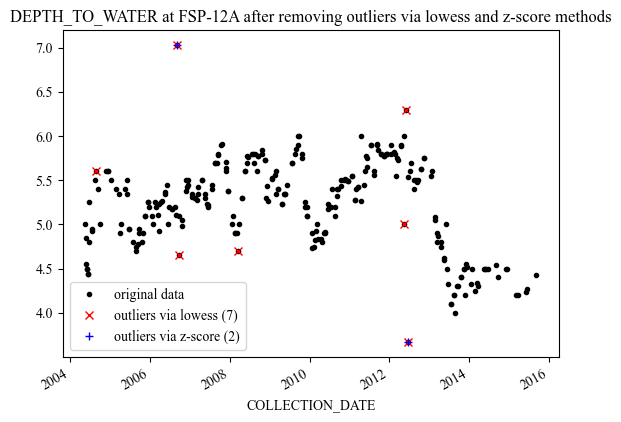

In [5]:
## using LOWESS fitting to remove outliers:

# set outliers to np.nan
wt_data_xOutliers = pylenm_df.remove_outliers_lowess(wt_data)

# identify outlier locations
outliers_loc = wt_data_xOutliers.compare(wt_data).index  # dates at which outliers occurred have had their values set to np.nan
outliers = wt_data.loc[outliers_loc]
num_outliers =  outliers.size

## removing outliers based on their z-score:
wt_data_xOutliers_zScore = pylenm_df.remove_outliers(wt_data, z_threshold=3)
outliers_loc_zScore = wt_data[~wt_data.isin(wt_data_xOutliers_zScore)].index
outliers_zScore = wt_data.loc[outliers_loc_zScore]
num_outliers_zScore =  outliers_zScore.size

wt_data.plot(style='.', label='original data', color='black')
outliers.plot(style='x', label=f'outliers via lowess ({num_outliers})', color='red')
outliers_zScore.plot(style='+', label=f'outliers via z-score ({num_outliers_zScore})', color='blue')
plt.legend()
plt.title(f'{ana} at {stn} after removing outliers via lowess and z-score methods')
plt.show()

For decreasing data like `DEPTH_TO_WATER` at FSP-12A, `remove_outliers_lowess()` identifies more points that deviate from the overall trend. Decreasing data like this doesn't occur very often at SRS, but it can occur more often at other contaminated sites, so this function is a key part of generalizing pylenm to other sites.

The way this function works is that it makes a LOWESS fit to the data, then calculates the difference between the data and the LOWESS fit (observation - fit). An "outlier" is defined as a data point outside a user-determined number of standard deviations of (observation - fit) (default is 2.2 standard deviations). The user can also tweak the LOWESS fit itself using the `lowess_frac` parameter; a smaller `lowess_frac` tends to capture more "local behaviour" in the fit. this parameter is described in more detail in the introduction.

You can see what's happening behind the scenes by setting `lowess_frac=True`:

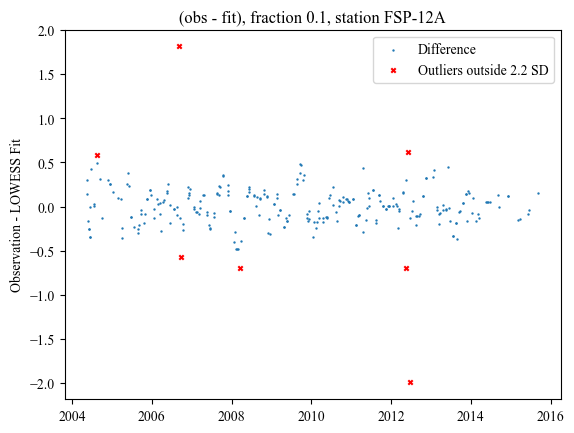

In [6]:
lowess_frac = 0.1
std_thresh = 2.2
wt_data_xOutliers, difference = pylenm_df.remove_outliers_lowess(wt_data, lowess_frac=lowess_frac, std_thresh=std_thresh, return_difference=True)

plt.scatter(difference.index, difference, s=0.5, label='Difference')
plt.scatter(difference[outliers_loc].index, difference[outliers_loc], s=10, marker='x', color='red', label=f'Outliers outside {std_thresh} SD')
plt.title("(obs - fit), fraction "+ str(lowess_frac) + ", station "+ str(stn))
plt.ylabel('Observation - LOWESS Fit')
plt.legend()
plt.show()

# Plotting Data

If we want to see the water table over time at some station, for example FBI 14D, then `plot_data_lowess()` will remove outliers (via a call to `remove_outliers_lowess()`) and plot the time series data alongside a smoothed LOWESS fit.

This function is similar to the default plot_data(), except it introduces LOWESS time-series outlier removal and uses LOWESS instead of Supersmoother.

If we want to see a plot of difference=observation-LOWESS fit, which was used to define and remove outliers, we can toggle that with `show_difference=True`

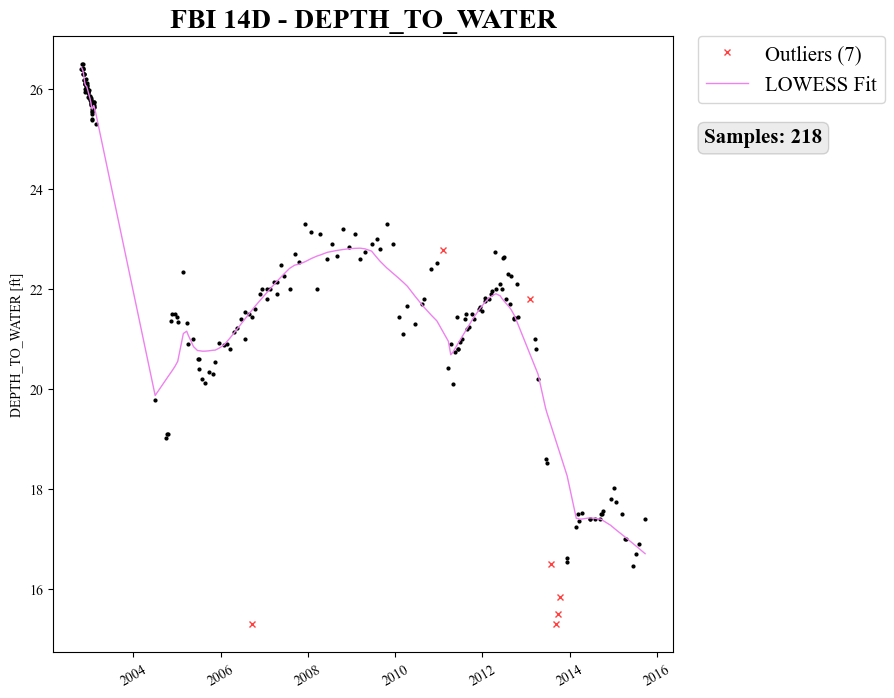

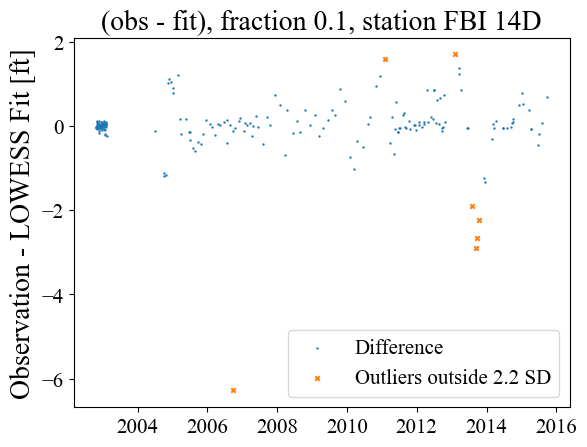

In [7]:
pylenm_df.plot_data_lowess(station_name='FBI 14D', analyte_name='DEPTH_TO_WATER', show_difference=True)

If we find that the LOWESS fit smooths the data a bit too much, we can use `plot_data_rollAvg()` instead. This function again removes outliers via LOWESS, and then takes a time average (default 1 week) centred around each data point and assigns the result to that point. This rolling time average is then plotted alongside the original data. The user can set the averaging period using `window='1W'`; where the valid inputs (ex. `'1W'`, `'4W'`, `'3D'`) are listed by pandas here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html

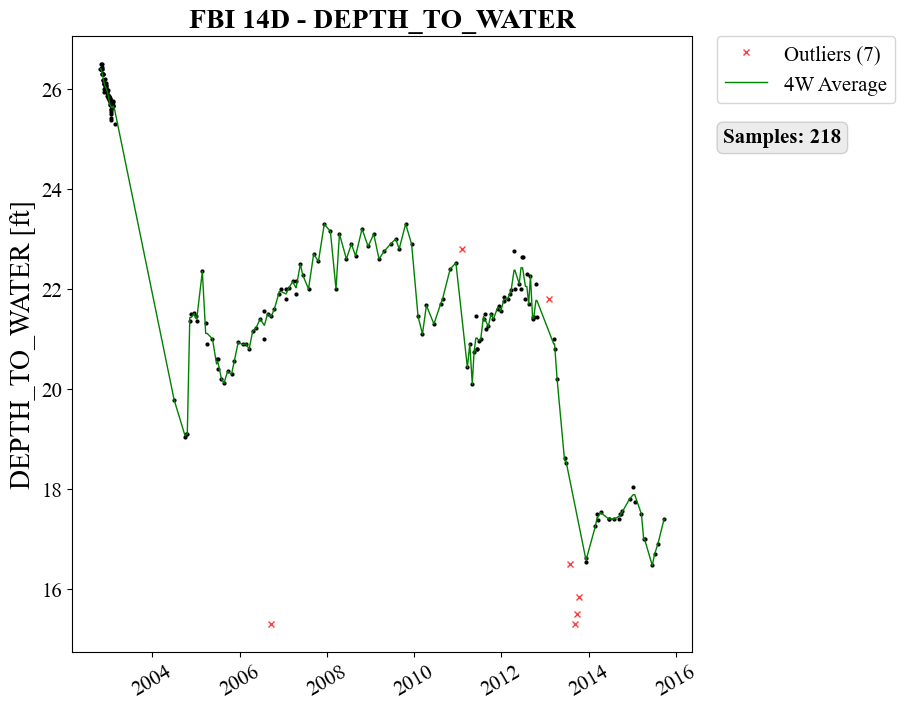

In [8]:
pylenm_df.plot_data_rollAvg(station_name='FBI 14D', analyte_name='DEPTH_TO_WATER', window='4W')
# pylenm_df.plot_data_rollAvg(station_name='FBI 14D', analyte_name='DEPTH_TO_WATER', window='8W')  # wider windows look smoother

Both of these functions are very customizable: the user can toggle on/off various settings including returning the data used in plotting, removing outliers, zooming into the data after outliers have been removed (some outliers are really far from the original data, which distorts the plot by auto-zooming way out), and more! The user can also customize the LOWESS outlier removal parameters (`std_thresh` and `lowess_frac`).

A full description of all of the inputs can be found in the source code, but feel free to play around with them on a new station below!

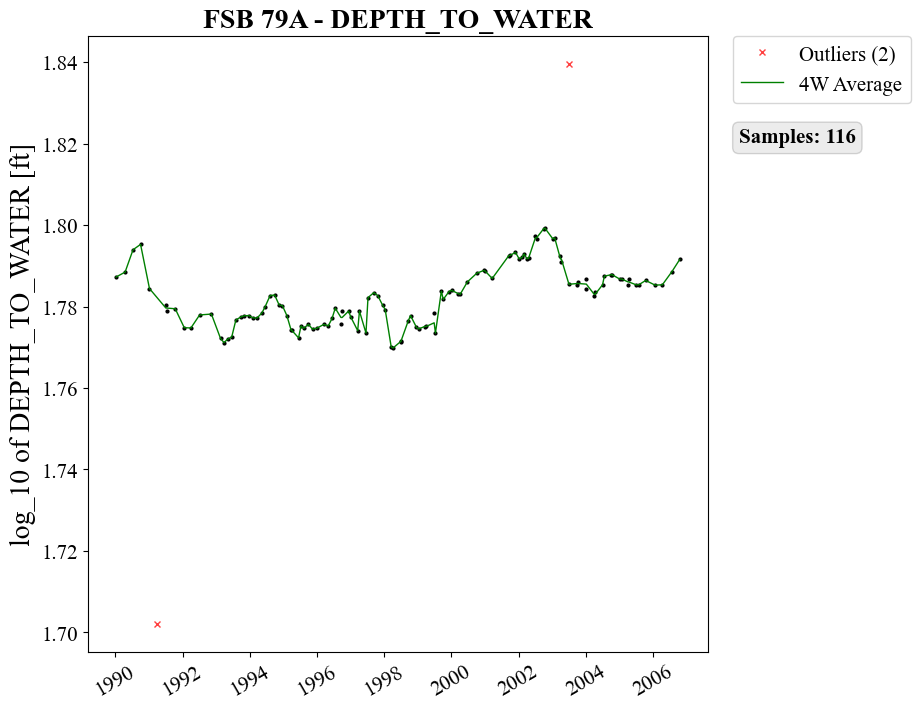

In [9]:
data_xOutliers, data_rollAvg, data_outliers = pylenm_df.plot_data_rollAvg(station_name='FSB 79A', analyte_name='DEPTH_TO_WATER',
                                                                          window='4W',
                                                                          # rm_outliers=False,
                                                                          std_thresh=2, 
                                                                          lowess_frac=0.1, 
                                                                          # show_difference=True, 
                                                                          x_label=None, 
                                                                          y_label=None, 
                                                                          year_interval=2, 
                                                                          log_transform=True, 
                                                                          # y_zoom=True, 
                                                                          return_data=True, 
                                                                          # save=True, 
                                                                          save_dir='plot_data_lowess', 
                                                                          # plot_inline=False, 
                                                                          save_as_pdf=True)

# Time Averaging and Aligning All Stations

The new `time_average_all_stations()` function aligns all stations' time series data (for one analyte) such that they all have measurements at the same dates. The user specifies a time period, ex. 4 weeks `'4W'`, and the function returns a Pandas DataFrame with stations as columns and dates as index, with the dates separated by the specified time period. At each station at each time, the DataFrame will be populated by the average value for that station from this time to the next (ex. a 4-week average). If the station has no data in that 4-week period, that entry will be `np.nan`.

This function can be thought of as an alternative to `interpolate_stations_by_analyte()` (formerly `interpolate_wells_by_analyte()`): the user specifies an analyte, and the function returns a Pandas DataFrame with stations as columns and times as index. However, `time_average_all_stations()` differs in a few notable ways:
- it uses `remove_outliers_lowess()` for time series outlier removal, instead of dropping based on z-score (ie distance from the mean of the data)
- it doesn't interpolate between data points, as this can introduce artifacts in less-predictable time series data
- it doesn't replace `np.nan` values with the average station value

In [10]:
time_period = '8W'
wt_avg = pylenm_df.time_average_all_stations(analyte='DEPTH_TO_WATER', period=time_period)
wt_avg

,FBI 14D,FBI 15D,FBI 17D,FEX 4,FIB 1,FIB 8,FM-2BD,FM-A7U,FMC-002F,FMC-002H,...,FSP 2A,FSP 2B,FSP 47A,FSP-072A,FSP-072B,FSP-12A,FSP204A,FSP226A,FSP249A,FSP249B
1989-11-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-03-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-04-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-06-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-03-01,17.166667,14.245,24.03,26.2,22.24,19.6,NaN,NaN,NaN,NaN,...,6.40,6.02,4.82,3.65,2.80,4.20,4.12,3.4,2.86,2.50
2015-04-26,16.470000,14.770,24.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.70,6.40,5.30,4.10,3.22,4.25,4.72,4.2,2.92,2.80
2015-06-21,16.800000,15.000,24.60,26.4,21.50,19.3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.43,3.60,NaN,NaN,NaN,NaN,NaN
2015-08-16,17.400000,15.400,25.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.16,7.50,NaN,4.33,3.45,4.43,5.70,NaN,3.70,3.34


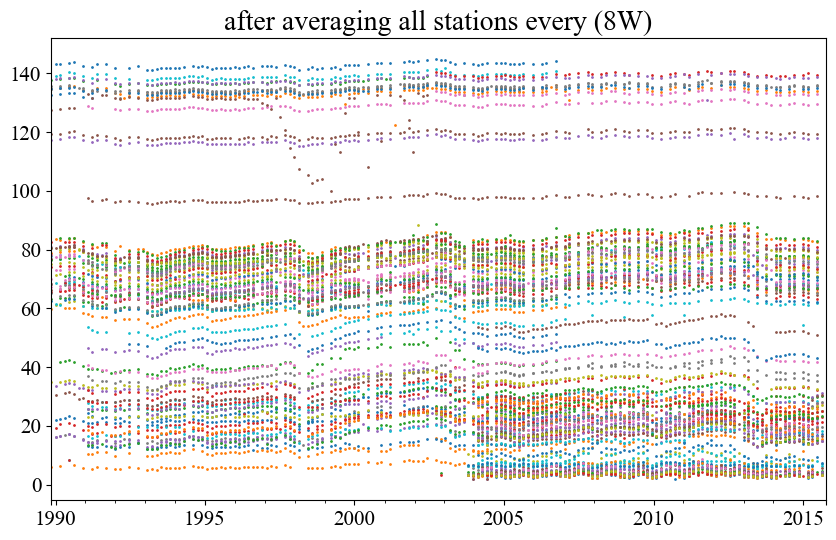

In [11]:
wt_avg.plot(style='.', ms=2, figsize=(10,6), title=f'after averaging all stations every ({time_period})', legend=False)
plt.show()

This function is particularly useful if you want to spatially interpolate between stations over time, because it gives all stations measurements at the same timesteps. Otherwise, potentially every station measures at different dates and times, making it difficult to define a single "timestep" at which to spatially interpolate.

However, if you want to use this function to interpolate via machine learning (ML), ML models typically do not understand `np.nan`, so you will need to drop all stations with NaN values at each timestep (or fill those nan values somehow). Below is an example of how to drop all stations with `np.nan` values to make an input appropriate for a Gaussian Process model as described here: https://fvgp.readthedocs.io/en/latest/api/GP.html

In [12]:
# get data for random timestep in wt_avg
random_timestep = pd.to_datetime('2015-03-01')
wt_avg_at_timestep = wt_avg.loc[random_timestep]

# get longitude/latitude for all stations in wt_avg (need location info to interpolate spatially)
station_lonlat = []
for station in wt_avg_at_timestep.index:
    if station in pylenm_df.construction_data.index.to_numpy():  # make sure this station exists in construction data
        lon = np.nanmean(pylenm_df.construction_data['LONGITUDE'][station])  # need to average because sometimes there are multiple entries
        lat = np.nanmean(pylenm_df.construction_data['LATITUDE'][station])
        if np.isnan(lon)==False and np.isnan(lat)==False:  # make sure station coordinates are not NaN
            station_lonlat.append([lon,lat])
station_lonlat_arr = np.array(station_lonlat)

# build ML input as an array X with shape (wt_avg_at_timestep.size, 3), then drop stations with np.nan data at this timestep
X_raw = np.array([station_lonlat_arr[:,0], station_lonlat_arr[:,1], wt_avg_at_timestep.to_numpy()]).T
X_nan = ~np.isnan(X_raw).any(axis=1)  # ML doesn't understand NaN, so need to identify rows of X (ie stations) with NaN values and remove those rows/stations
X = X_raw[X_nan]
print('Before dropping stations with np.nan:\n', X_raw, '\n')
print('After dropping stations with np.nan:\n', X)

Before dropping stations with np.nan:
 [[-81.6774153   33.27162418  17.16666667]
 [-81.67738325  33.2709165   14.245     ]
 [-81.67801569  33.27081556  24.03      ]
 [-81.67978285  33.27036953  26.2       ]
 [-81.67845571  33.27096946  22.24      ]
 [-81.67817112  33.27133411  19.6       ]
 [-81.67353774  33.27100088          nan]
 [-81.6863021   33.26234403          nan]
 [-81.67906676  33.2665425           nan]
 [-81.66825811  33.27281534          nan]
 [-81.67844657  33.2706489           nan]
 [-81.68003614  33.2702203   27.34      ]
 [-81.6800733   33.27019059  23.        ]
 [-81.67690287  33.27168575  20.2       ]
 [-81.67988081  33.26946969  21.79      ]
 [-81.67988537  33.26943814  13.89      ]
 [-81.68218193  33.26894429  19.9       ]
 [-81.6813115   33.26855628   2.885     ]
 [-81.67971739  33.26779226   6.29      ]
 [-81.67878775  33.27003888   6.2       ]
 [-81.67780875  33.26898915   2.4       ]
 [-81.67780875  33.26898915   2.6       ]
 [-81.6767944   33.26977849   4.1    